# Install & Import

In [1]:
# Install
!pip install pulp --quiet
!pip install ultralytics --quiet


# Import Libraries
import os
import subprocess
import asyncio
import importlib
import time
import shutil
import random
import copy
import glob
import pulp
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
subprocess.run(['pip', 'install', 'ultralytics'], capture_output=True)
from ultralytics import YOLO
from ultralytics.data.dataset import ClassificationDataset
from ultralytics.models.yolo.classify import ClassificationTrainer, ClassificationValidator
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from datetime import datetime
from sklearn.model_selection import KFold, GroupShuffleSplit
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

E0000 00:00:1762692508.247383      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762692508.311025      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check GPU Availability
torch.cuda.empty_cache()
print(torch.cuda.is_available())

True


# EDA

In [2]:
# Path & Variables

home_path = "/kaggle/working"
dataset_path = "/kaggle/input/dataset-s1-v2"
folder_save = "/kaggle/working/results"
class_names = ['3dmask', 'deepfake', 'print', 'real', 'replay']
num_classes = len(class_names)

random.seed(42)

In [ ]:
# Dataset Distribution

def count_images_in_classes(folder_path):
    """Count the number of images in each class folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Display dataset distribution using a bar graph."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

datasets_class_counts = count_images_in_classes(dataset_path)
print(f"Dataset distribution: {datasets_class_counts}")
plot_distribution(datasets_class_counts, "Dataset Distribution")

In [ ]:
# Preview Datasets

def preview_images(folder_path, title, samples_per_class=5):
    import os
    import matplotlib.pyplot as plt
    from PIL import Image

    # Get all classes (folders)
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))

    # Flatten axes for easy indexing
    axes = axes.flatten() if num_classes * samples_per_class > 1 else [axes]

    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Filter images starting with class name
        sample_images = [img for img in images if img.startswith(cls + "_")][:samples_per_class]

        for j in range(samples_per_class):
            ax = axes[i * samples_per_class + j]
            ax.axis('off')

            if j < len(sample_images):
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path).convert("RGB")
                ax.imshow(img)
                if j == 0:
                    ax.set_title(cls)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Preview images in folder
preview_images(dataset_path, "Dataset Preview", samples_per_class=5)

# Data Split

In [ ]:
# Define the output path
output_base_dir = "/kaggle/working/dataset-s1-v2-602020"  # Output directory name
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
os.makedirs(output_base_dir, exist_ok=True)

# Initialize lists to store file paths, labels, and video IDs
file_paths = []
labels = []
video_ids = []

# Scan dataset folders and collect image file information
print("Scanning dataset folders...")
for folder in class_names:
    class_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(class_path):
        print(f"Warning: Directory not found at {class_path}. Skipping.")
        continue
    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_file_path = os.path.join(class_path, filename)
            file_paths.append(full_file_path)
            labels.append(folder)
            # Generate unique video ID based on folder and filename
            base_video_id = os.path.splitext(filename)[0].split('_')[0]
            unique_video_id = f"{folder}_{base_video_id}"
            video_ids.append(unique_video_id)

# Create a DataFrame to store the collected data
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels,
    'video_id': video_ids
})

# Encode labels numerically
df['label_encoded'], unique_labels = pd.factorize(df['label'])
class_names = unique_labels.tolist()

# Print dataset statistics
print(f"\nFound {len(df)} total frames from {df['video_id'].nunique()} unique videos.")
print(f"Class names: {class_names}")
print("\n" + "="*60 + "\n")

# Perform stratified splitting: 70% train, 15% val, 15% test
# print("Performing stratified split (70% train, 15% val, 15% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.15,
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1765,  # 15% of original = 17.65% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 65% train, 15% val, 20% test
# print("Performing stratified split (65% train, 15% val, 20% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.20,  # 20% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1875,  # 15% of original = 18.75% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 65% train, 20% val, 15% test
# print("Performing stratified split (65% train, 20% val, 15% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.15,  # 15% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.2353,  # 20% of original = 23.53% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 80% train, 10% val, 10% test
# print("Performing stratified split (80% train, 10% val, 10% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.10,  # 10% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1111,  # 10% of original = 11.11% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 60% train, 20% val, 20% test
print("Performing stratified split (60% train, 20% val, 20% test)...")
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,  # 20% for test
    random_state=42,
    stratify=df['label_encoded']
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,  # 20% of original = 25% of (train+val)
    random_state=42,
    stratify=train_val_df['label_encoded']
)

# Print split statistics
print("\nSplit complete. Final set sizes:")
print(f"Training set: {len(train_df)} frames ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} frames ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} frames ({len(test_df)/len(df)*100:.1f}%)")
print("\n" + "="*60 + "\n")

# Create output directory structure
print("Creating output directory structure...")
os.makedirs(output_base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(output_base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Copy files to respective split folders
print("Copying files to split folders...")
def copy_files(df, split_name):
    for _, row in df.iterrows():
        src_path = row['file_path']
        class_name = row['label']
        # Generate unique filename to avoid overwrites
        filename = os.path.basename(src_path)
        base, ext = os.path.splitext(filename)
        unique_filename = f"{base}_{uuid.uuid4().hex[:8]}{ext}"
        dest_path = os.path.join(output_base_dir, split_name, class_name, unique_filename)
        shutil.copy2(src_path, dest_path)

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

# Verify the number of files in each split and class
print("\nVerifying output directory contents...")
for split in ['train', 'val', 'test']:
    print(f"\n{split.capitalize()} set:")
    split_dir = os.path.join(output_base_dir, split)
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        num_files = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {class_name}: {num_files} files")
print("\nDataset splitting and organization complete!")

# Data Augmentation

In [3]:
# Define Transforms
output_size = (224, 224)

crop_factor = 0.5
crop_size = (int(output_size[0] * crop_factor), int(output_size[1] * crop_factor))

transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    v2.RandomPerspective(distortion_scale=0.1, p=0.3),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomErasing(p=0.15, scale=(0.02, 0.15)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_flip = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_rotate = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation(10),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_crop = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_coljit = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_affine = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_perspective = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomPerspective(distortion_scale=0.1, p=0.3),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_noise = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_blur = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_erase = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomErasing(p=0.15, scale=(0.02, 0.15)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_ori = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.GaussianNoise(mean=0, sigma=0.02),
    # v2.GaussianBlur(kernel_size=1, sigma=0.3),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_val_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensemble

In [4]:
import logging
logging.getLogger("ultralytics").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

In [6]:
# Liveness Ensemble Pipeline (Grid Search Accuracy-ACER-based)
class LivenessEnsemblePipeline:
    def __init__(self, yolo_model, effnet_path, device, val_loader, step=0.001):
        self.device = device
        self.classes = ['3dmask', 'deepfake', 'print', 'real', 'replay']

        # Load YOLOv11-cls (as YOLO object, already initialized outside)
        print("--- Loading model: Yolo11-cls ---")
        self.yolo_model = YOLO(yolo_model_path)
        self.yolo_model_core = self.yolo_model.model
        self.yolo_model_core.to(device).eval()
        self.yolo_model_names = self.yolo_model.names
        print(f"Model successfully loaded")

        # Load EfficientNetV2
        print("\n--- Loading model type: EfficientNetV2 ---")
        self.effnet_model = models.efficientnet_v2_s(weights=None)
        num_ftrs = self.effnet_model.classifier[1].in_features
        self.effnet_model.classifier[1] = nn.Linear(num_ftrs, len(self.classes))
        state_dict = torch.load(effnet_path, map_location=device)
        self.effnet_model.load_state_dict(state_dict)
        self.effnet_model.to(device).eval()
        print(f"Model successfully loaded from: {effnet_path}")

        # Grid search for single weights (overall ACER)
        self.weights = self._grid_search_weights(val_loader, step)
        print(f"Optimal weights (Yolo11-cls, EfficientNetV2): {self.weights}")

    # Metric calculation
    def _calculate_metrics(self, all_labels, all_preds):
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
    
        # BPCER
        total_real = np.sum(np.array(all_labels) == real_idx)
        fn_real = np.sum((np.array(all_preds)[np.array(all_labels) == real_idx] != real_idx))
        bpcer = fn_real / total_real if total_real > 0 else 0.0
    
        # APCER per attack class
        apcer_dict = {}
        for atk_idx in attack_indices:
            atk_mask = np.array(all_labels) == atk_idx
            total_atk = np.sum(atk_mask)
            fp_atk = np.sum(np.array(all_preds)[atk_mask] == real_idx)
            apcer_dict[self.classes[atk_idx]] = fp_atk / total_atk if total_atk > 0 else 0.0
    
        # APCER overall
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0
    
        acer = (bpcer + apcer_overall) / 2
        return bpcer, apcer_dict, apcer_overall, acer

    # Weighted ensemble ACER
    def _ensemble_acer(self, weights, probs_list, labels):
        ensemble_probs = weights[0] * probs_list[0] + weights[1] * probs_list[1]
        preds = np.argmax(ensemble_probs, axis=1)
        _, _, acer = self._calculate_metrics(labels, preds)
        return acer

    # Grid search for one weight per model (based on combined Accuracy + ACER)
    def _grid_search_weights(self, val_loader, step=0.001, alpha=0.5):
        print(f"\n--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α={alpha}) ---")
        best_score = -float('inf')
        best_weight = None
        best_acc = 0.0
        best_acer = 1.0

        yolo_probs, effnet_probs, all_labels = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)

                # YOLO predictions
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_probs.extend(torch.softmax(yolo_out, dim=1).cpu().numpy())

                # EffNet predictions
                effnet_out = self.effnet_model(images)
                effnet_probs.extend(torch.softmax(effnet_out, dim=1).cpu().numpy())

                all_labels.extend(labels.numpy())

        yolo_probs = np.array(yolo_probs)
        effnet_probs = np.array(effnet_probs)
        all_labels = np.array(all_labels)
        probs_list = [yolo_probs, effnet_probs]

        for w_yolo in np.arange(0, 1 + step, step):
            w_effnet = 1.0 - w_yolo
            ensemble_probs = w_yolo * yolo_probs + w_effnet * effnet_probs
            ensemble_preds = np.argmax(ensemble_probs, axis=1)

            acc = accuracy_score(all_labels, ensemble_preds)
            _, _, _, acer = self._calculate_metrics(all_labels, ensemble_preds)

            # Combined score (maximize accuracy, minimize ACER)
            score = alpha * acc - (1 - alpha) * acer

            print(f"Weights [Yolo: {w_yolo:.4f}, EffNet: {w_effnet:.4f}] -> Accuracy: {acc:.4f}, ACER: {acer:.4f}, Combined Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_acc = acc
                best_acer = acer
                best_weight = [w_yolo, w_effnet]

        print(f"\nBest Combination on val set -> Accuracy: {best_acc:.4f}, ACER: {best_acer:.4f}")
        print(f"Optimal Weights: [Yolo: {best_weight[0]:.4f}, EffNet: {best_weight[1]:.4f}] (Score={best_score:.4f})")
        return best_weight



    # Prediction single image
    def predict_single(self, image_path):
        # YOLO Prediction
        yolo_class, yolo_conf, yolo_probs, yolo_time = self._predict_yolo(image_path)
        self._print_single_results("Yolo11-cls", yolo_class, yolo_conf, yolo_probs, yolo_time)
        
        # EfficientNet Prediction
        effnet_class, effnet_conf, effnet_probs, effnet_time = self._predict_effnet(image_path)
        self._print_single_results("EfficientNetV2", effnet_class, effnet_conf, effnet_probs, effnet_time)
        
        # Ensemble Prediction
        ensemble_class, ensemble_conf, ensemble_probs, ensemble_time = self._predict_ensemble(yolo_probs, effnet_probs)
        # Gunakan format sama dengan _print_single_results
        self._print_single_results("Ensemble", ensemble_class, ensemble_conf, ensemble_probs, ensemble_time)

    # Model-specific prediction
    def _predict_yolo(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.yolo_model_core(image_tensor)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_idx = np.argmax(probs)
        return self.classes[pred_idx], probs[pred_idx], probs, 0

    def _predict_effnet(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.effnet_model(image_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_idx = np.argmax(probs)
        return self.classes[pred_idx], probs[pred_idx], probs, 0

    def _predict_ensemble(self, yolo_probs, effnet_probs):
        w_yolo, w_effnet = self.weights
        ensemble_probs = w_yolo * yolo_probs + w_effnet * effnet_probs
        pred_idx = np.argmax(ensemble_probs)
        return self.classes[pred_idx], ensemble_probs[pred_idx], ensemble_probs, 0

    def _print_single_results(self, model_name, pred_class, conf, probs, time_taken):
        print(f"\n--- Prediction Results ---")
        print(f"Model: {model_name}")
        print(f"Predicted Class: {pred_class}")
        print(f"Confidence Level: {conf:.4f}")
        print("Probabilities for all classes:")
        for i, cls in enumerate(self.classes):
            print(f"* {cls.capitalize()}: {probs[i]:.4f}")
        print(f"Prediction completed in {time_taken:.4f} seconds.")
    
    # Full evaluation method
    def evaluate(self, test_loader):
        print("\n--- Evaluating Models ---")
        self._evaluate_model(test_loader, self.yolo_model_core, "Yolo11-cls")
        self._evaluate_model(test_loader, self.effnet_model, "EfficientNetV2")
        self._evaluate_ensemble(test_loader)

    def _evaluate_model(self, loader, model, name):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        report = classification_report(all_labels, all_preds, target_names=self.classes, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        bpcer, apcer_dict, apcer_overall, acer = self._calculate_metrics(all_labels, all_preds)

        # APCER Overall
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0

        print(f"\n--- Evaluation of Model: {name} ---")
        print(report)
        print(f"Accuracy: {acc:.4f}, BPCER: {bpcer:.4f}, APCER Overall: {apcer_overall:.4f}, ACER: {acer:.4f}")
        print("APCER per attack class:")
        for cls, val in apcer_dict.items():
            print(f"* {cls}: {val:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    def _evaluate_ensemble(self, loader):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device)

                # YOLO probs
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_probs = torch.softmax(yolo_out, dim=1).cpu().numpy()

                # EffNet probs
                eff_out = self.effnet_model(images)
                eff_probs = torch.softmax(eff_out, dim=1).cpu().numpy()

                # Ensemble predictions
                batch_preds = []
                for y_probs, e_probs in zip(yolo_probs, eff_probs):
                    _, _, ens_probs, _ = self._predict_ensemble(y_probs, e_probs)
                    batch_preds.append(np.argmax(ens_probs))
                all_preds.extend(batch_preds)
                all_labels.extend(labels.numpy())

        report = classification_report(all_labels, all_preds, target_names=self.classes, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        bpcer, apcer_dict, apcer_overall, acer = self._calculate_metrics(all_labels, all_preds)

        # APCER Overall
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0

        print(f"\n--- Evaluation of Model: Ensemble ---")
        print(report)
        print(f"Accuracy: {acc:.4f}, BPCER: {bpcer:.4f}, APCER Overall: {apcer_overall:.4f}, ACER: {acer:.4f}")
        print("APCER per attack class:")
        for cls, val in apcer_dict.items():
            print(f"* {cls}: {val:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title("Confusion Matrix for Ensemble Model")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()


    # AUC and ROI
    def evaluate_with_roc(self, test_loader):
        """
        ROC Curve + AUC (One-vs-Rest) for 3 models:
        - YOLOv11
        - EfficientNetV2
        - Ensemble (weighted)
        Output: 1 plot + tabel AUC per class + macro-average AUC
        """
        print("\n" + "="*70)
        print(" ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)")
        print("="*70)

        # Koleksi probabilitas
        y_true = []
        yolo_probs_all   = []
        effnet_probs_all = []
        ensemble_probs_all = []

        self.yolo_model_core.eval()
        self.effnet_model.eval()

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels_np = labels.cpu().numpy()
                y_true.extend(labels_np)

                # YOLOv11
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_prob = torch.softmax(yolo_out, dim=1).cpu().numpy()
                yolo_probs_all.extend(yolo_prob)

                # EfficientNetV2
                eff_out = self.effnet_model(images)
                eff_prob = torch.softmax(eff_out, dim=1).cpu().numpy()
                effnet_probs_all.extend(eff_prob)

                # Ensemble
                w_y, w_e = self.weights
                ens_prob = w_y * yolo_prob + w_e * eff_prob
                ensemble_probs_all.extend(ens_prob)

        # Convert to array
        y_true = np.array(y_true)
        yolo_probs_all   = np.array(yolo_probs_all)
        effnet_probs_all = np.array(effnet_probs_all)
        ensemble_probs_all = np.array(ensemble_probs_all)

        # Binarize labels (One-vs-Rest)
        n_classes = len(self.classes)
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        # Model dictionary
        models = {
            'YOLOv11': yolo_probs_all,
            'EfficientNetV2': effnet_probs_all,
            'Ensemble': ensemble_probs_all
        }

        # Setup plot
        plt.figure(figsize=(7, 5))
        colors = cycle(['blue', 'orange', 'red'])  # biru, oranye, hijau

        # AUC Table
        print("\nAUC PER CLASS (One-vs-Rest)\n")
        print(f"{'Class':<12} {'YOLOv11':<10} {'EffNetV2':<12} {'Ensemble':<10}")
        print("-" * 55)

        # Calculate AUC per class + plot per-class
        fpr_dict = {}
        tpr_dict = {}
        auc_dict = {}

        for i, cls in enumerate(self.classes):
            auc_scores = []
            for name, probs in models.items():
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
                roc_auc = auc(fpr, tpr)
                auc_scores.append(roc_auc)

                if name not in fpr_dict:
                    fpr_dict[name] = []
                    tpr_dict[name] = []
                    auc_dict[name] = []
                fpr_dict[name].append(fpr)
                tpr_dict[name].append(tpr)
                auc_dict[name].append(roc_auc)

            print(f"{cls.capitalize():<12} {auc_scores[0]:.4f}     {auc_scores[1]:.4f}       {auc_scores[2]:.4f}")

        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr_dict['YOLOv11'][i] for i in range(n_classes)]))
        macro_aucs = {}

        for name in models.keys():
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr_dict[name][i], tpr_dict[name][i])
            mean_tpr /= n_classes
            mean_tpr[0] = 0.0
            mean_tpr[-1] = 1.0
            macro_auc = auc(all_fpr, mean_tpr)
            macro_aucs[name] = macro_auc

            color = next(colors)
            plt.plot(all_fpr, mean_tpr,
                     color=color, lw=1.2, linestyle='-',
                     label=f'{name} macro-avg (AUC = {macro_auc:.4f})')

        # Diagonal Line
        plt.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random (AUC = 0.50)')

        # Plot Finalization
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Multi-class ROC Curve (One-vs-Rest)', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print final macro AUC
        print(f"\n{'='*60}")
        print("FINAL MACRO-AVERAGE AUC")
        print(f"{'='*60}")
        for name, mauc in macro_aucs.items():
            print(f"{name:15}: {mauc:.4f}")
        print(f"{'='*60}")


    # Time Evaluation
    def benchmark_inference_time(self, test_loader):
        """
        Measure inference time on THE ENTIRE test set
        Output: Clean table + FPS
        """
        print("\n" + "="*70)
        print(" INFERENCE TIME BENCHMARK (ON FULL TEST SET)")
        print("="*70)

        # Calculate test set data
        total_images = len(test_loader.dataset)
        print(f"Test set size: {total_images:,} images")

        # Timer lists
        yolo_times = []
        effnet_times = []
        ensemble_times = []

        self.yolo_model_core.eval()
        self.effnet_model.eval()

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(self.device)
                batch_size = images.size(0)

                # === YOLOv11 ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                _ = self.yolo_model_core(images)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                yolo_times.append(time.time() - start)

                # === EfficientNetV2 ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                _ = self.effnet_model(images)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                effnet_times.append(time.time() - start)

                # === Ensemble (full pipeline) ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                y_out = self.yolo_model_core(images)
                e_out = self.effnet_model(images)
                w_y, w_e = self.weights
                ens_out = w_y * torch.softmax(y_out[0] if isinstance(y_out, tuple) else y_out, dim=1) + \
                          w_e * torch.softmax(e_out, dim=1)
                _ = torch.argmax(ens_out, dim=1)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                ensemble_times.append(time.time() - start)

        # Calculate time average
        avg_yolo = (sum(yolo_times) / total_images) * 1000
        avg_eff  = (sum(effnet_times) / total_images) * 1000
        avg_ens  = (sum(ensemble_times) / total_images) * 1000

        std_yolo = (np.std(yolo_times) / np.sqrt(len(yolo_times))) * 1000 / (total_images / len(yolo_times))
        std_eff  = (np.std(effnet_times) / np.sqrt(len(effnet_times))) * 1000 / (total_images / len(effnet_times))
        std_ens  = (np.std(ensemble_times) / np.sqrt(len(ensemble_times))) * 1000 / (total_images / len(ensemble_times))

        # Print table
        print(f"\n{'Model':<20} {'Time (ms)':<15} {'FPS':<8} {'± std'}")
        print("-" * 65)
        print(f"{'YOLOv11-cls':<20} {avg_yolo:6.4f}       {1000/avg_yolo:6.4f}    ± {std_yolo:.4f}")
        print(f"{'EfficientNetV2':<20} {avg_eff:6.4f}       {1000/avg_eff:6.4f}    ± {std_eff:.4f}")
        print(f"{'Ensemble':<20} {avg_ens:6.4f}       {1000/avg_ens:6.4f}    ± {std_ens:.4f}")
        print("-" * 65)
        print(f"Real-time threshold: >30 FPS → Ensemble: {1000/avg_ens:.4f} FPS")

        return {
            'total_images': total_images,
            'yolo_ms': avg_yolo, 'effnet_ms': avg_eff, 'ensemble_ms': avg_ens,
            'yolo_fps': 1000/avg_yolo, 'effnet_fps': 1000/avg_eff, 'ensemble_fps': 1000/avg_ens
        }


# Transform
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


single_image_path = os.path.join('/kaggle/input/dataset-s1/real/real_05_0001.jpg')

# Baseline

## Dataset Concat

In [7]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [8]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_train)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_ori])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [9]:
BATCH_SIZE=32

In [10]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [15]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [16]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [17]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [18]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [19]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5257 Acc: 0.8473 | Val Loss: 1.1244 Acc: 0.8722 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2085 Acc: 0.9387 | Val Loss: 1.0787 Acc: 0.8970 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1579 Acc: 0.9515 | Val Loss: 1.0496 Acc: 0.9052 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1286 Acc: 0.9594 | Val Loss: 1.0376 Acc: 0.9148 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1138 Acc: 0.9623 | Val Loss: 1.0270 Acc: 0.9168 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1023 Acc: 0.9674 | Val Loss: 1.0180 Acc: 0.9188 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.0944 Acc: 0.9689 | Val Loss: 1.0076 Acc: 0.9277 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0886 Acc: 0.9711 | Val Loss: 1.0142 Acc: 0.9157 | 
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0841 Acc: 0.9718 | Va

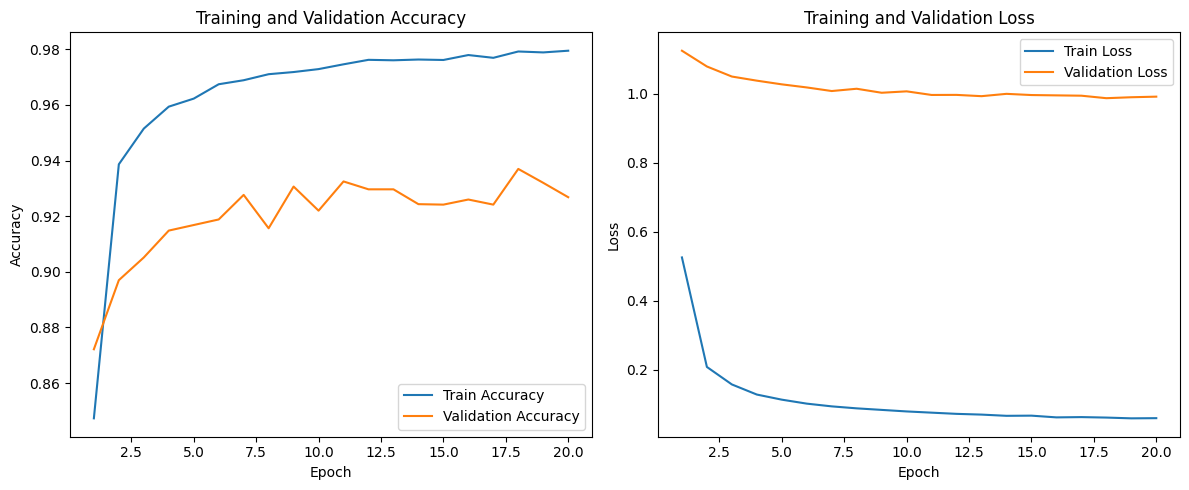

In [20]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.97      0.96      0.97      1200
    deepfake       0.84      0.94      0.89      1200
       print       1.00      0.94      0.97      1200
        real       0.87      0.83      0.85      1200
      replay       1.00      0.99      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.93      0.93      6000



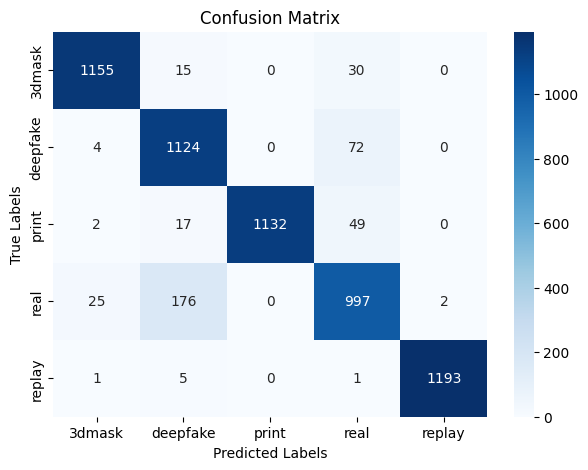

In [22]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_baseline_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-10_baseline_0.9370/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-10_baseline_0.9370/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-10_baseline_0.9370


## EfficientNetV2

In [24]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [25]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 215MB/s]


In [26]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [27]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [28]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9224 Acc: 0.7838 | Val Loss: 0.5671 Acc: 0.8890 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4617 Acc: 0.8911 | Val Loss: 0.3974 Acc: 0.8990 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3488 Acc: 0.9047 | Val Loss: 0.3158 Acc: 0.9127 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.2964 Acc: 0.9096 | Val Loss: 0.2873 Acc: 0.9162 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2643 Acc: 0.9149 | Val Loss: 0.2499 Acc: 0.9237 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2449 Acc: 0.9186 | Val Loss: 0.2251 Acc: 0.9280 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2296 Acc: 0.9232 | Val Loss: 0.2236 Acc: 0.9262 | 
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2114 Acc: 0.9285 | Val Loss: 0.2057 Acc: 0.9305 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.204

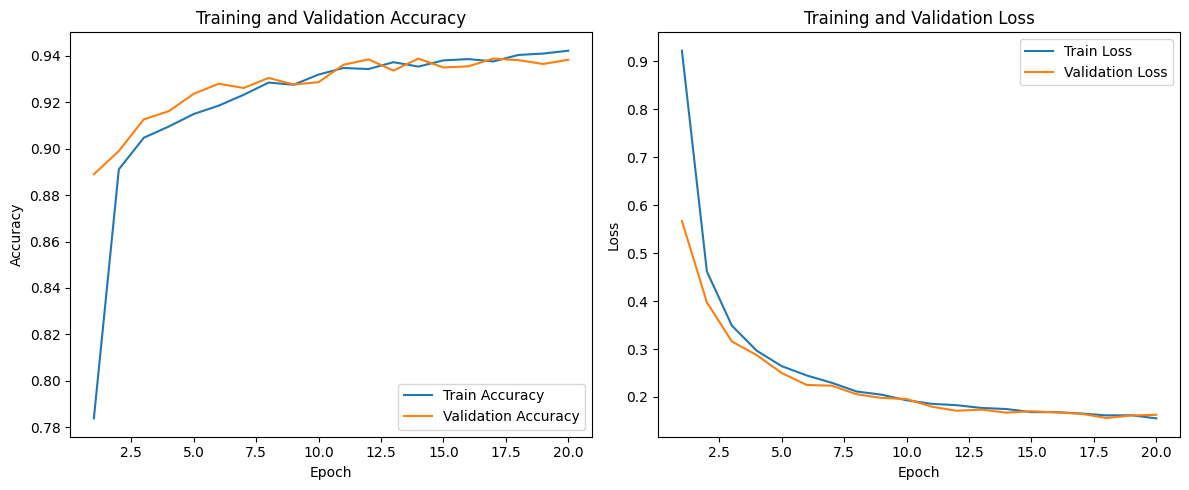

In [29]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.83      0.89      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.79      0.83      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



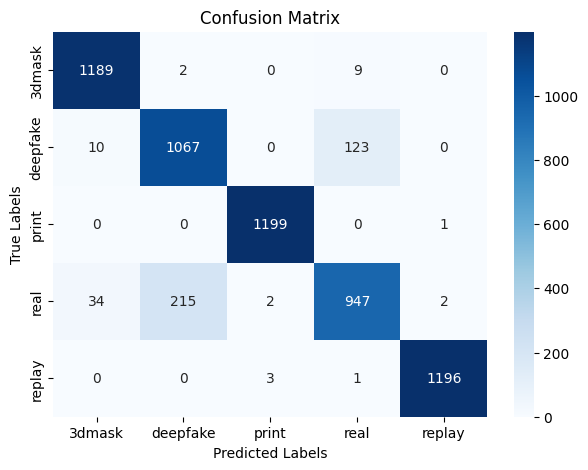

In [31]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_baseline_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-10_baseline_0.9388/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-10_baseline_0.9388/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-10_baseline_0.9388/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-10_baseline_0.9388


## Ensemble Weighted Average

In [12]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-10_baseline_0.9370/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-10_baseline_0.9388/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [14]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-10_baseline_0.9388/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9385, ACER: 0.1116, Combined Score: 0.4135
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9383, ACER: 0.1120, Combined Score: 0.4132
Weights

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [40]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)

=== Inference Test ===

--- Prediction Results ---
Model: Yolo11-cls
Predicted Class: real
Confidence Level: 0.3845
Probabilities for all classes:
* 3dmask: 0.1513
* Deepfake: 0.1617
* Print: 0.1513
* Real: 0.3845
* Replay: 0.1513
Prediction completed in 0.0389 seconds.

--- Prediction Results ---
Model: EfficientNetV2
Predicted Class: real
Confidence Level: 0.5997
Probabilities for all classes:
* 3dmask: 0.0145
* Deepfake: 0.3852
* Print: 0.0001
* Real: 0.5997
* Replay: 0.0005
Prediction completed in 0.0416 seconds.

--- Prediction Results ---
Model: Ensemble
Predicted Class: real
Confidence Level: 0.4400
Probabilities for all classes:
* 3dmask: 0.1160
* Deepfake: 0.2194
* Print: 0.1123
* Real: 0.4400
* Replay: 0.1124
Prediction completed in 0.0000 seconds.



=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.98      0.97      0.97      1200
    deepfake       0.85      0.94      0.89      1200
       print       1.00      0.94      0.97      1200
        real       0.87      0.85      0.86      1200
      replay       1.00      0.99      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9363, BPCER: 0.1483, APCER Overall: 0.0317, ACER: 0.0900
APCER per attack class:
* 3dmask: 0.0167
* deepfake: 0.0642
* print: 0.0408
* replay: 0.0050


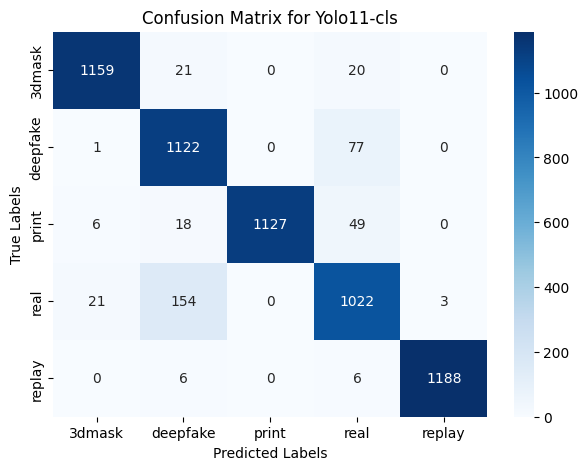


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.83      0.89      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.79      0.83      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9337, BPCER: 0.2117, APCER Overall: 0.0279, ACER: 0.1198
APCER per attack class:
* 3dmask: 0.0092
* deepfake: 0.1025
* print: 0.0000
* replay: 0.0000


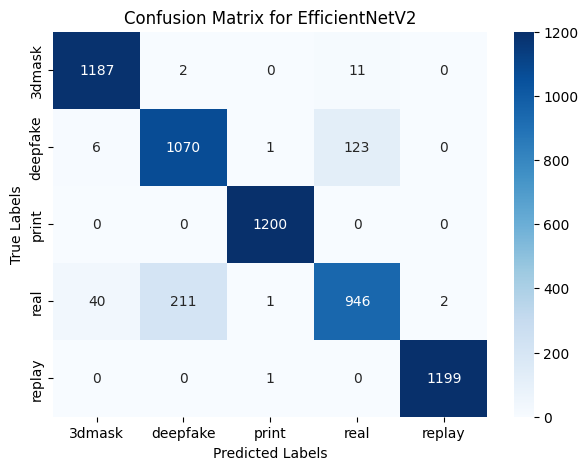


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.88      0.97      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.96      0.86      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000

Accuracy: 0.9647, BPCER: 0.1425, APCER Overall: 0.0081, ACER: 0.0753
APCER per attack class:
* 3dmask: 0.0017
* deepfake: 0.0300
* print: 0.0008
* replay: 0.0000


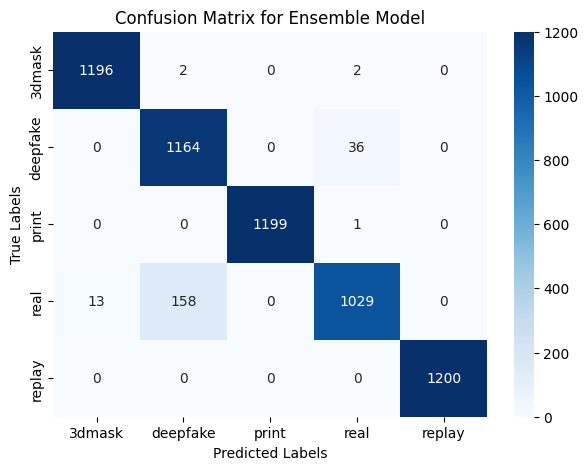

In [15]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [16]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3668       2726.4725    ± 0.0014
EfficientNetV2       1.7092       585.0755    ± 0.0044
Ensemble             2.0710       482.8513    ± 0.0053
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.8513 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9974     0.9995       1.0000
Deepfake     0.9867     0.9842       0.9945
Print        0.9993     1.0000       1.0000
Real         0.9787     0.9795       0.9931
Replay       1.0000     1.0000       1.0000


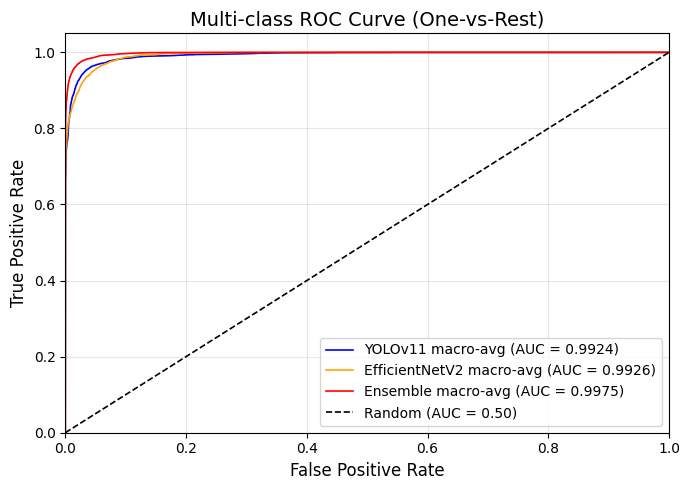


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9924
EfficientNetV2 : 0.9926
Ensemble       : 0.9975


In [17]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Flip

## Dataset Concat

In [44]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [45]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_flip)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [47]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [48]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [49]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [51]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [52]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [53]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5148 Acc: 0.8560 | Val Loss: 1.1233 Acc: 0.8682 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2093 Acc: 0.9364 | Val Loss: 1.0745 Acc: 0.8870 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1552 Acc: 0.9526 | Val Loss: 1.0489 Acc: 0.9038 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1321 Acc: 0.9583 | Val Loss: 1.0357 Acc: 0.9128 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1154 Acc: 0.9634 | Val Loss: 1.0271 Acc: 0.9127 | 
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1043 Acc: 0.9662 | Val Loss: 1.0191 Acc: 0.9195 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.0984 Acc: 0.9671 | Val Loss: 1.0159 Acc: 0.9185 | 
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0901 Acc: 0.9699 | Val Loss: 1.0061 Acc: 0.9258 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0855 Acc: 0.9716 | Val Loss: 1.0035 Acc: 0.927

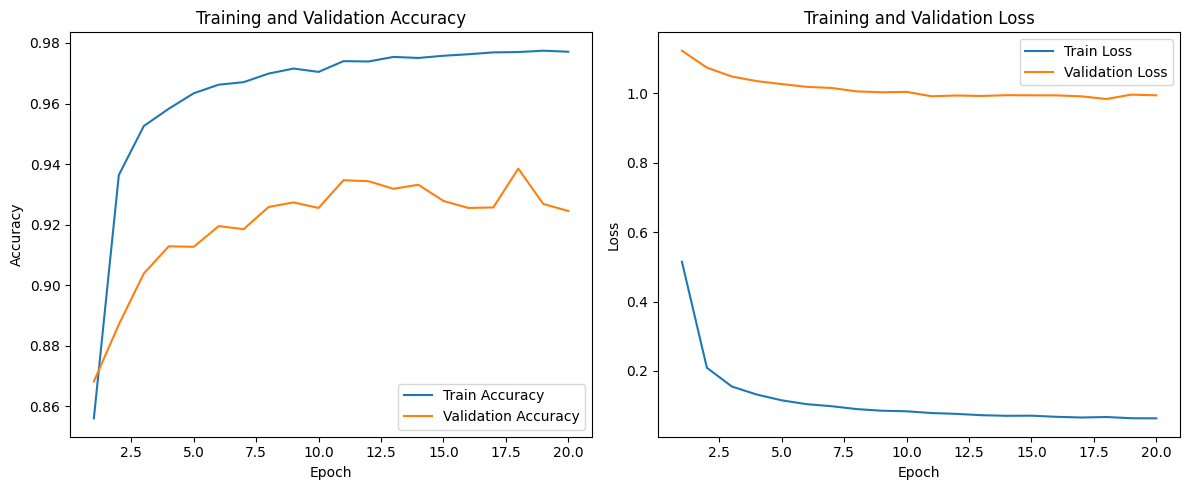

In [54]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.97      0.96      0.97      1200
    deepfake       0.85      0.95      0.90      1200
       print       1.00      0.94      0.97      1200
        real       0.87      0.85      0.86      1200
      replay       1.00      0.98      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



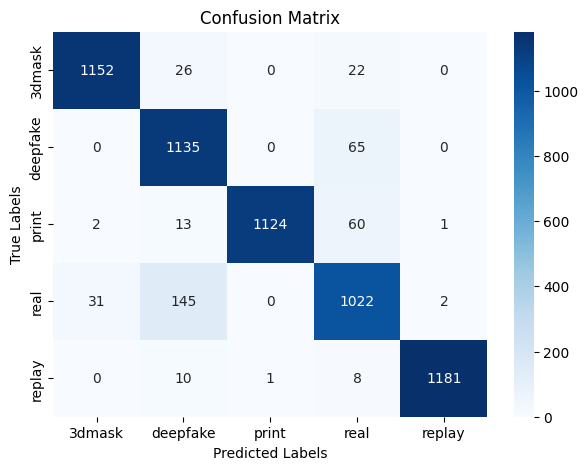

In [56]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [57]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_flip_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-11_flip_0.9385/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-11_flip_0.9385/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-11_flip_0.9385


## EfficientNetV2

In [58]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [59]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [60]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [61]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [62]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9102 Acc: 0.7816 | Val Loss: 0.5680 Acc: 0.8757 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4611 Acc: 0.8909 | Val Loss: 0.3896 Acc: 0.8982 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3540 Acc: 0.9013 | Val Loss: 0.3203 Acc: 0.9157 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.2973 Acc: 0.9111 | Val Loss: 0.2781 Acc: 0.9202 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2722 Acc: 0.9116 | Val Loss: 0.2528 Acc: 0.9180 | 
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2474 Acc: 0.9203 | Val Loss: 0.2294 Acc: 0.9247 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2315 Acc: 0.9207 | Val Loss: 0.2137 Acc: 0.9258 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2172 Acc: 0.9242 | Val Loss: 0.2032 Acc: 0.9302 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.209

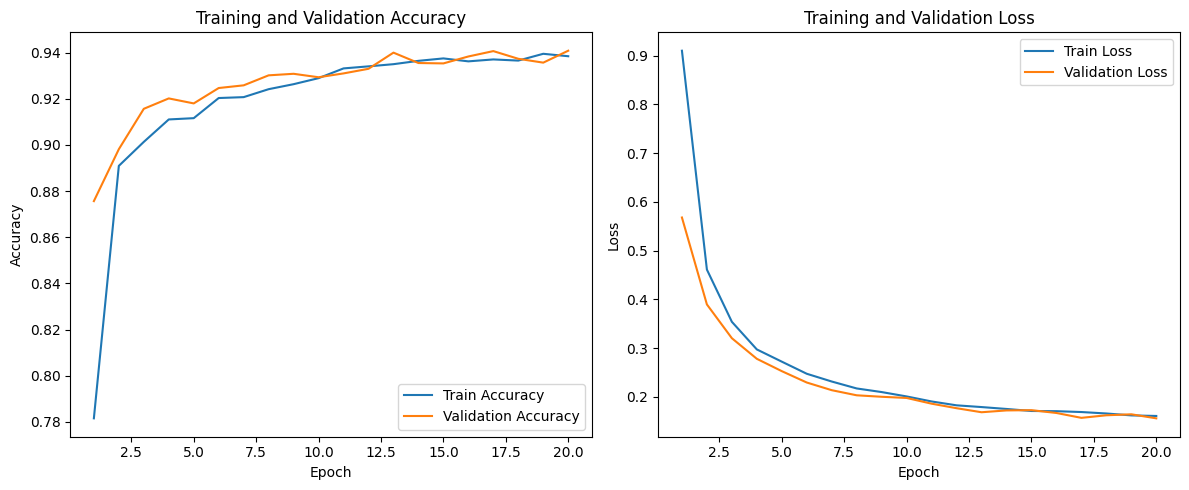

In [63]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.84      0.90      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.89      0.80      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



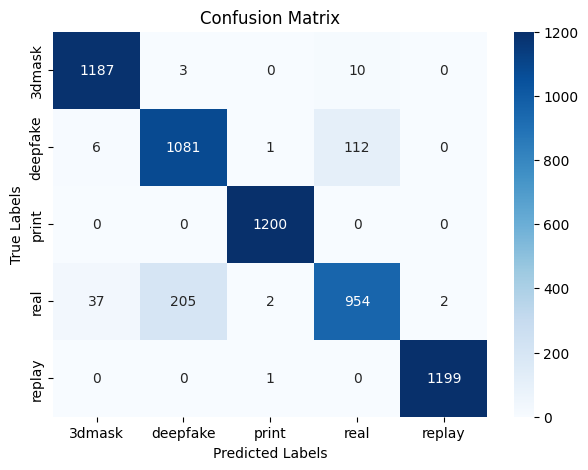

In [65]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [66]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_flip_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-11_flip_0.9408/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-11_flip_0.9408/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-11_flip_0.9408/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-11_flip_0.9408


## Ensemble Weighted Average

In [355]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-11_flip_0.9385/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-11_flip_0.9408/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [356]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-11_flip_0.9408/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9427, ACER: 0.1037, Combined Score: 0.4195
Weights [Yo

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [69]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)

=== Inference Test ===

--- Prediction Results ---
Model: Yolo11-cls
Predicted Class: real
Confidence Level: 0.3925
Probabilities for all classes:
* 3dmask: 0.1503
* Deepfake: 0.1565
* Print: 0.1503
* Real: 0.3925
* Replay: 0.1503
Prediction completed in 0.0093 seconds.

--- Prediction Results ---
Model: EfficientNetV2
Predicted Class: real
Confidence Level: 0.4838
Probabilities for all classes:
* 3dmask: 0.1960
* Deepfake: 0.3191
* Print: 0.0006
* Real: 0.4838
* Replay: 0.0005
Prediction completed in 0.0196 seconds.

--- Prediction Results ---
Model: Ensemble
Predicted Class: real
Confidence Level: 0.3945
Probabilities for all classes:
* 3dmask: 0.1513
* Deepfake: 0.1600
* Print: 0.1470
* Real: 0.3945
* Replay: 0.1471
Prediction completed in 0.0000 seconds.



=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.97      0.97      0.97      1200
    deepfake       0.86      0.94      0.90      1200
       print       1.00      0.93      0.97      1200
        real       0.86      0.86      0.86      1200
      replay       1.00      0.98      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9363, BPCER: 0.1433, APCER Overall: 0.0346, ACER: 0.0890
APCER per attack class:
* 3dmask: 0.0192
* deepfake: 0.0583
* print: 0.0558
* replay: 0.0050


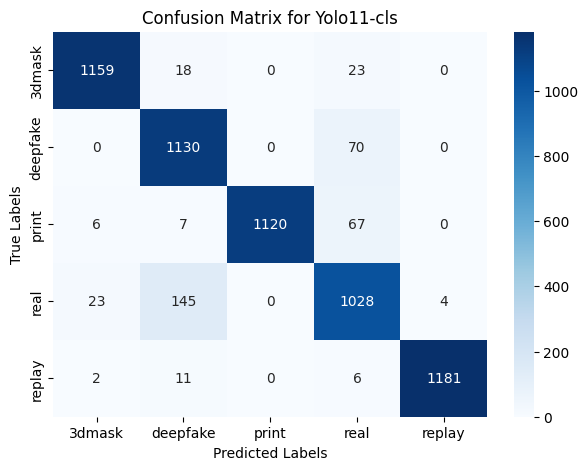


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.96      0.98      0.97      1200
    deepfake       0.83      0.89      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.79      0.83      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9322, BPCER: 0.2100, APCER Overall: 0.0275, ACER: 0.1187
APCER per attack class:
* 3dmask: 0.0100
* deepfake: 0.1000
* print: 0.0000
* replay: 0.0000


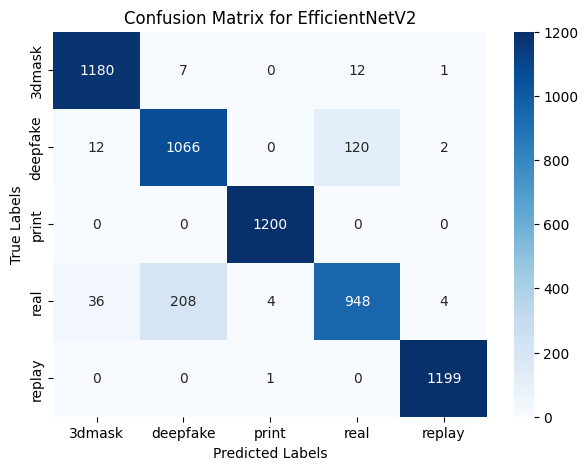


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      0.99      0.99      1200
    deepfake       0.88      0.98      0.93      1200
       print       1.00      1.00      1.00      1200
        real       0.97      0.86      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

Accuracy: 0.9670, BPCER: 0.1350, APCER Overall: 0.0071, ACER: 0.0710
APCER per attack class:
* 3dmask: 0.0042
* deepfake: 0.0233
* print: 0.0008
* replay: 0.0000


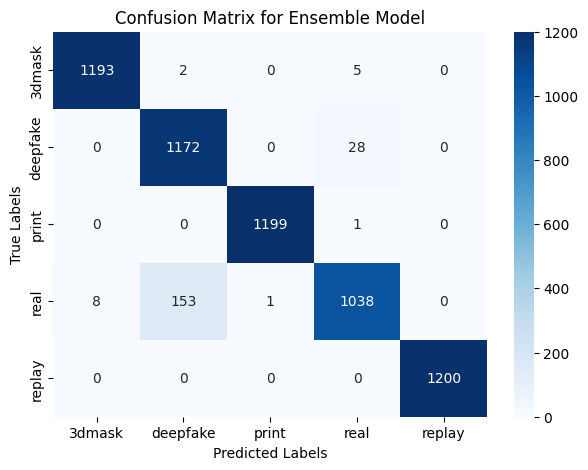

In [357]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [358]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3679       2717.7782    ± 0.0013
EfficientNetV2       1.7090       585.1224    ± 0.0044
Ensemble             2.0713       482.7991    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.7991 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9972     0.9997       1.0000
Deepfake     0.9869     0.9858       0.9953
Print        0.9987     1.0000       1.0000
Real         0.9770     0.9820       0.9938
Replay       0.9999     1.0000       1.0000


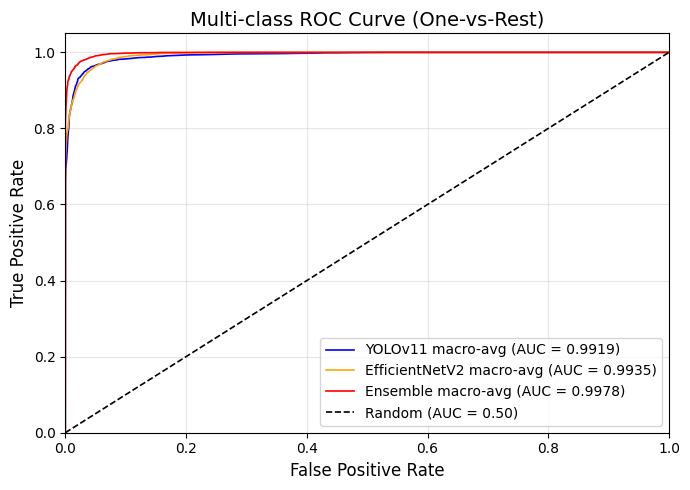


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9919
EfficientNetV2 : 0.9935
Ensemble       : 0.9978


In [359]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Rotation

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_rotate)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [80]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [81]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [82]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [83]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [84]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [85]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5516 Acc: 0.8464 | Val Loss: 1.1258 Acc: 0.8743 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2291 Acc: 0.9302 | Val Loss: 1.0720 Acc: 0.8965 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1760 Acc: 0.9439 | Val Loss: 1.0523 Acc: 0.9032 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1478 Acc: 0.9503 | Val Loss: 1.0400 Acc: 0.9075 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1353 Acc: 0.9541 | Val Loss: 1.0227 Acc: 0.9218 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1215 Acc: 0.9584 | Val Loss: 1.0242 Acc: 0.9150 | 
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1122 Acc: 0.9611 | Val Loss: 1.0183 Acc: 0.9237 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.1064 Acc: 0.9623 | Val Loss: 1.0090 Acc: 0.9265 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0989 Acc: 0.9655 | Va

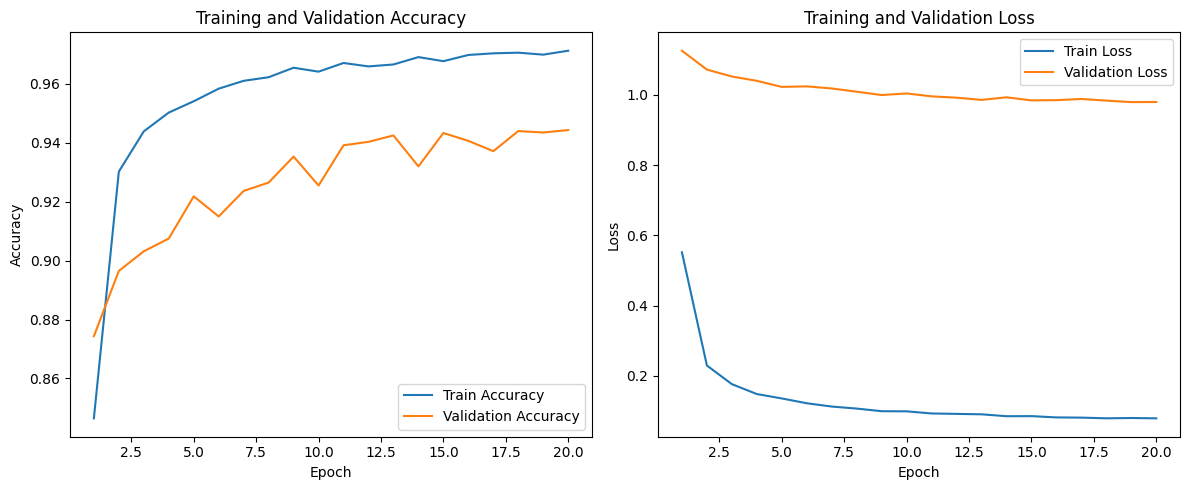

In [86]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      0.96      0.98      1200
    deepfake       0.86      0.95      0.90      1200
       print       1.00      0.98      0.99      1200
        real       0.91      0.86      0.89      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



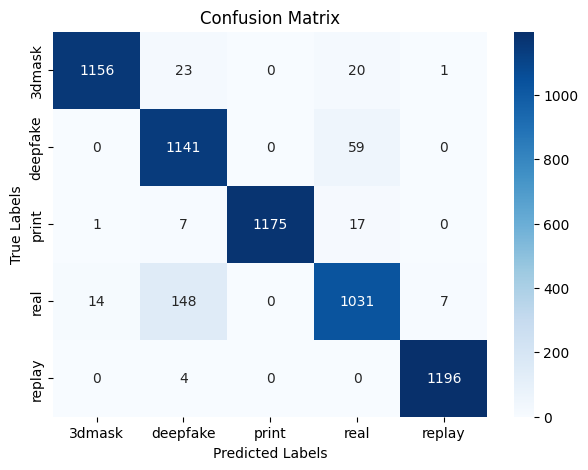

In [88]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [89]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_rotate_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-12_rotate_0.9443/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-12_rotate_0.9443/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-12_rotate_0.9443


## EfficientNetV2

In [91]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [93]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [94]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [96]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [97]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9234 Acc: 0.7842 | Val Loss: 0.5495 Acc: 0.8905 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4781 Acc: 0.8854 | Val Loss: 0.3828 Acc: 0.8987 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3639 Acc: 0.9007 | Val Loss: 0.3117 Acc: 0.9148 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3169 Acc: 0.9049 | Val Loss: 0.2727 Acc: 0.9165 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2822 Acc: 0.9082 | Val Loss: 0.2445 Acc: 0.9213 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2622 Acc: 0.9133 | Val Loss: 0.2272 Acc: 0.9225 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2441 Acc: 0.9173 | Val Loss: 0.2110 Acc: 0.9290 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2295 Acc: 0.9197 | Val Loss: 0.2014 Acc: 0.9322 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000

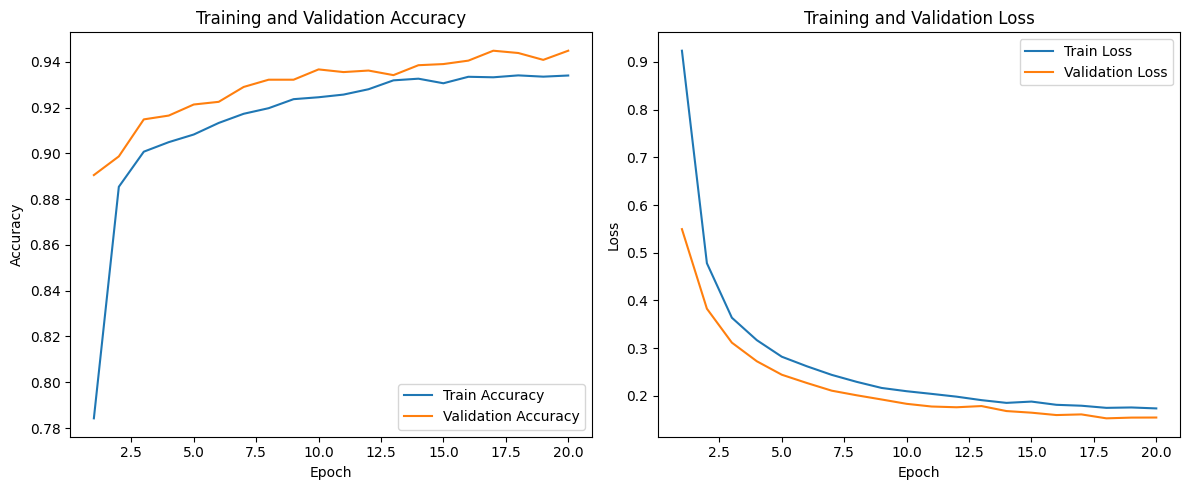

In [98]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.95      0.99      0.97      1200
    deepfake       0.83      0.92      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.91      0.76      0.83      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



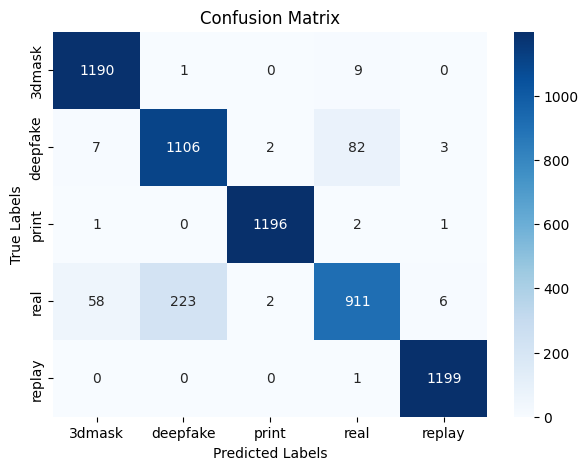

In [100]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [101]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_rotate_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-13_rotate_0.9448/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-13_rotate_0.9448/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-13_rotate_0.9448/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-13_rotate_0.9448


## Ensemble Weighted Average

In [360]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-12_rotate_0.9443/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-13_rotate_0.9448/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [110]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-13_rotate_0.9448/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9408, ACER: 0.1150, Combined Score: 0.4129
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9410, ACER: 0.1146, Combined Score: 0.4132
Weights [

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.98      0.97      0.98      1200
    deepfake       0.86      0.96      0.91      1200
       print       1.00      0.97      0.98      1200
        real       0.92      0.85      0.88      1200
      replay       0.99      0.99      0.99      1200

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Accuracy: 0.9495, BPCER: 0.1467, APCER Overall: 0.0196, ACER: 0.0831
APCER per attack class:
* 3dmask: 0.0142
* deepfake: 0.0383
* print: 0.0250
* replay: 0.0008


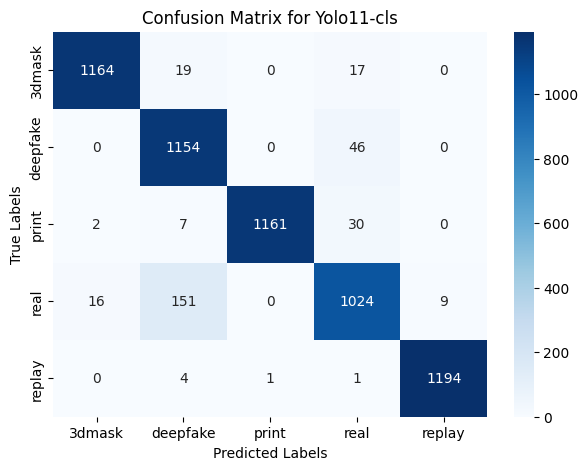


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.95      0.99      0.97      1200
    deepfake       0.82      0.92      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.91      0.75      0.82      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9328, BPCER: 0.2475, APCER Overall: 0.0192, ACER: 0.1333
APCER per attack class:
* 3dmask: 0.0067
* deepfake: 0.0692
* print: 0.0008
* replay: 0.0000


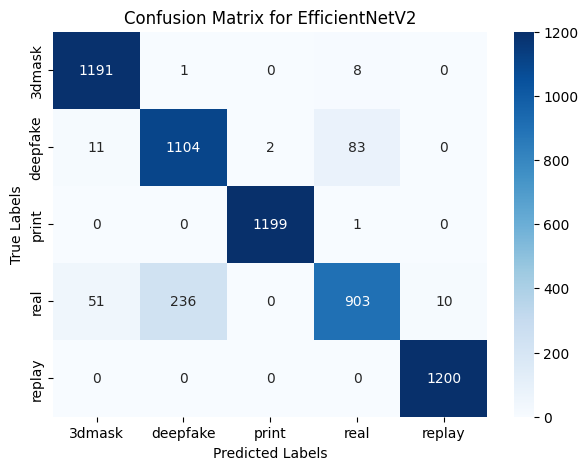


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      0.99      0.99      1200
    deepfake       0.87      0.98      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.97      0.85      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000

Accuracy: 0.9640, BPCER: 0.1525, APCER Overall: 0.0058, ACER: 0.0792
APCER per attack class:
* 3dmask: 0.0042
* deepfake: 0.0192
* print: 0.0000
* replay: 0.0000


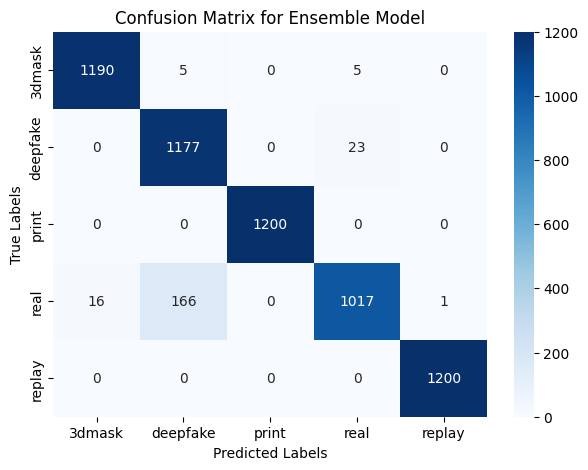

In [111]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [112]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3691       2709.4150    ± 0.0020
EfficientNetV2       1.7094       584.9936    ± 0.0044
Ensemble             2.0722       482.5823    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.5823 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9981     0.9996       0.9999
Deepfake     0.9884     0.9846       0.9947
Print        0.9998     1.0000       1.0000
Real         0.9824     0.9799       0.9934
Replay       1.0000     1.0000       1.0000


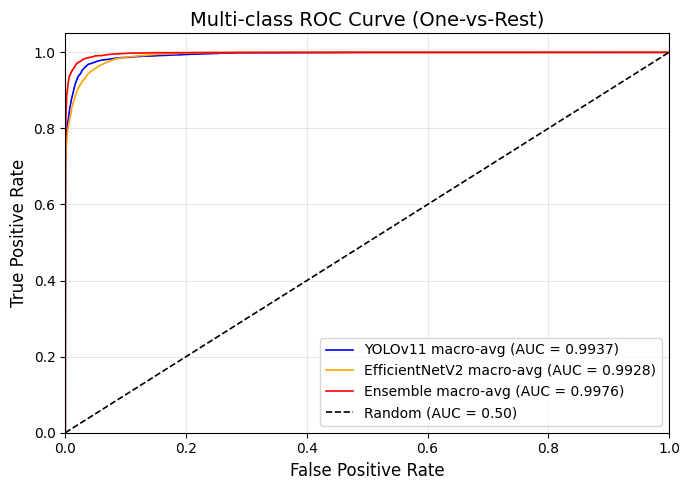


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9937
EfficientNetV2 : 0.9928
Ensemble       : 0.9976


In [113]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Crop

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [114]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_crop)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [116]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [117]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [118]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [119]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [120]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [121]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5436 Acc: 0.8443 | Val Loss: 1.1383 Acc: 0.8485 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2163 Acc: 0.9363 | Val Loss: 1.0845 Acc: 0.8770 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1606 Acc: 0.9494 | Val Loss: 1.0635 Acc: 0.8838 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1365 Acc: 0.9553 | Val Loss: 1.0575 Acc: 0.8767 | 
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1193 Acc: 0.9617 | Val Loss: 1.0466 Acc: 0.8877 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1070 Acc: 0.9627 | Val Loss: 1.0346 Acc: 0.9012 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1011 Acc: 0.9651 | Val Loss: 1.0293 Acc: 0.9062 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0949 Acc: 0.9673 | Val Loss: 1.0277 Acc: 0.9035 | 
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0907 Acc: 0.9696 | Val Loss: 1.0152 Acc: 0.915

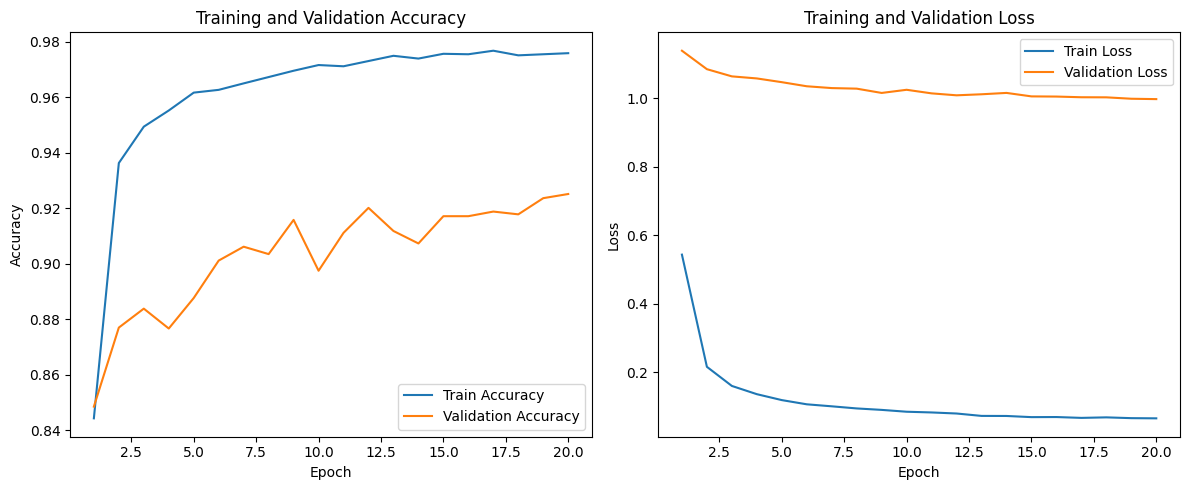

In [122]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [123]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      0.93      0.96      1200
    deepfake       0.81      0.92      0.86      1200
       print       1.00      0.95      0.97      1200
        real       0.81      0.83      0.82      1200
      replay       1.00      0.96      0.98      1200

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



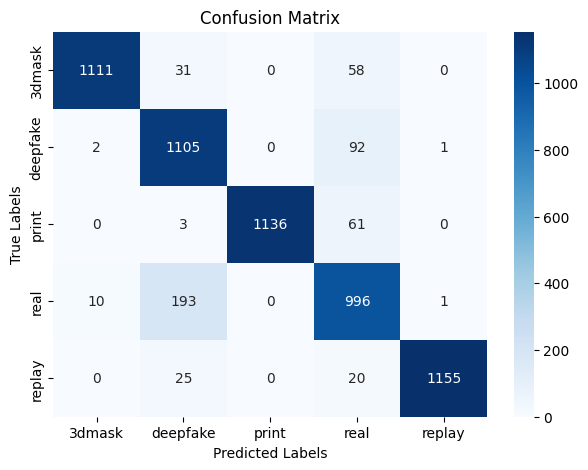

In [124]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [125]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_crop_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-13_crop_0.9252/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-13_crop_0.9252/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-13_crop_0.9252


## EfficientNetV2

In [127]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [129]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [131]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [132]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [133]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9144 Acc: 0.7960 | Val Loss: 0.5787 Acc: 0.8787 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4638 Acc: 0.8905 | Val Loss: 0.3961 Acc: 0.9003 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3557 Acc: 0.9022 | Val Loss: 0.3137 Acc: 0.9098 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3020 Acc: 0.9094 | Val Loss: 0.2787 Acc: 0.9195 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2698 Acc: 0.9152 | Val Loss: 0.2503 Acc: 0.9233 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2481 Acc: 0.9197 | Val Loss: 0.2385 Acc: 0.9222 | 
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2286 Acc: 0.9229 | Val Loss: 0.2196 Acc: 0.9282 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2204 Acc: 0.9253 | Val Loss: 0.2092 Acc: 0.9287 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.208

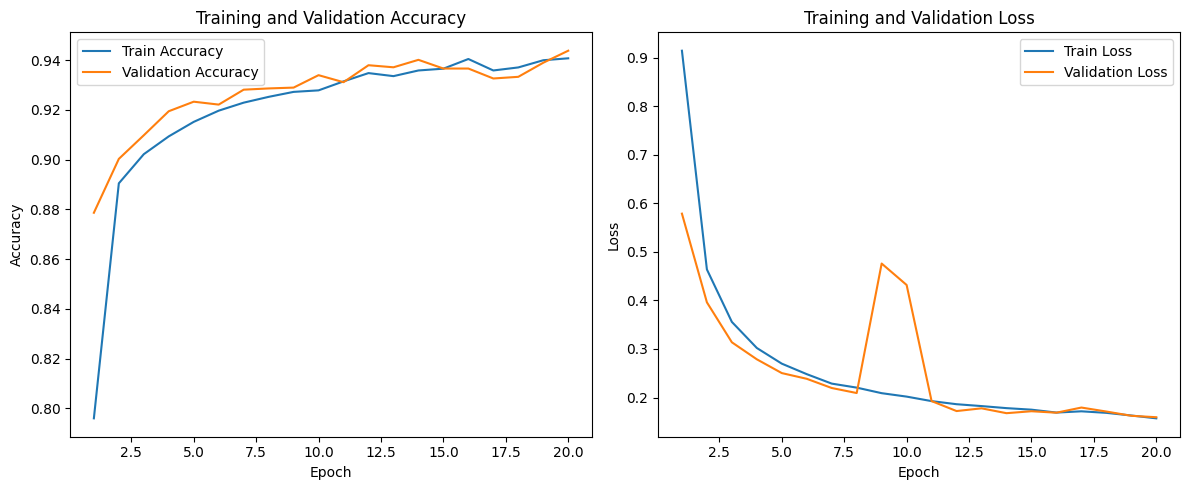

In [134]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [135]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.97      1200
    deepfake       0.86      0.87      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.86      0.82      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.93      0.94      0.93      6000
weighted avg       0.93      0.94      0.93      6000



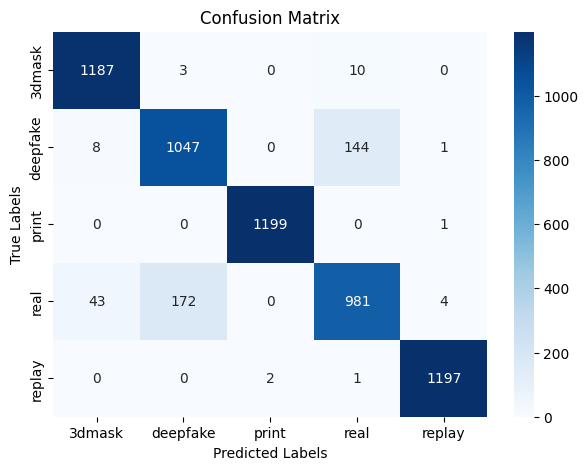

In [136]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [137]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_crop_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-14_crop_0.9438/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-14_crop_0.9438/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-14_crop_0.9438/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-14_crop_0.9438


## Ensemble Weighted Average

In [138]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-13_crop_0.9252/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-14_crop_0.9438/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [139]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-14_crop_0.9438/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9427, ACER: 0.0995, Combined Score: 0.4216
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9427, ACER: 0.0995, Combined Score: 0.4216
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9427, ACER: 0.0995, Combined Score: 0.4216
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9428, ACER: 0.0994, Combined Score: 0.4217
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9428, ACER: 0.0994, Combined Score: 0.4217
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9428, ACER: 0.0994, Combined Score: 0.4217
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9428, ACER: 0.0994, Combined Score: 0.4217
Weights [Yo

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      0.93      0.96      1200
    deepfake       0.82      0.92      0.87      1200
       print       1.00      0.95      0.97      1200
        real       0.82      0.84      0.83      1200
      replay       1.00      0.97      0.98      1200

    accuracy                           0.92      6000
   macro avg       0.93      0.92      0.92      6000
weighted avg       0.93      0.92      0.92      6000

Accuracy: 0.9217, BPCER: 0.1567, APCER Overall: 0.0467, ACER: 0.1017
APCER per attack class:
* 3dmask: 0.0450
* deepfake: 0.0817
* print: 0.0475
* replay: 0.0125


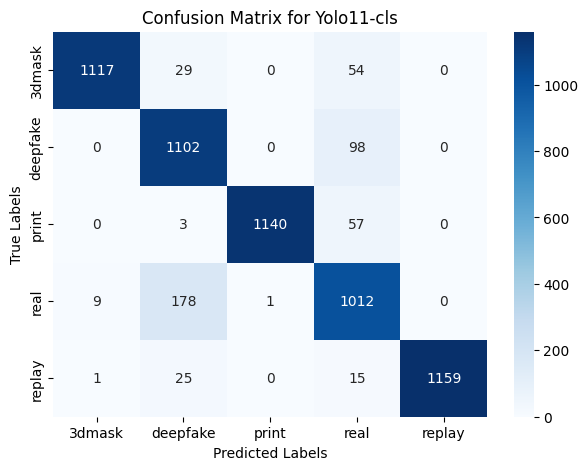


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.97      1200
    deepfake       0.85      0.87      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.86      0.81      0.83      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9333, BPCER: 0.1925, APCER Overall: 0.0323, ACER: 0.1124
APCER per attack class:
* 3dmask: 0.0067
* deepfake: 0.1217
* print: 0.0000
* replay: 0.0008


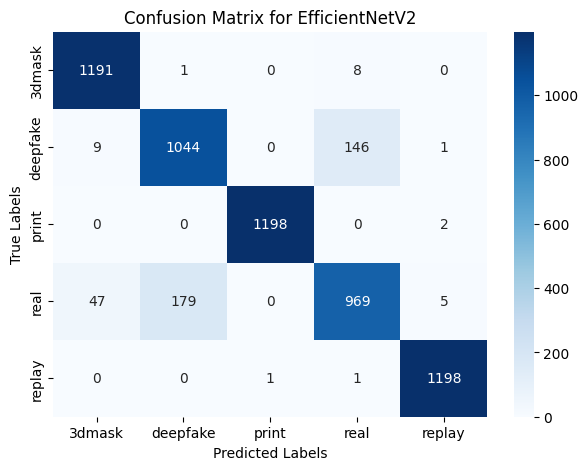


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      0.99      0.99      1200
    deepfake       0.88      0.95      0.91      1200
       print       1.00      1.00      1.00      1200
        real       0.94      0.86      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9598, BPCER: 0.1425, APCER Overall: 0.0144, ACER: 0.0784
APCER per attack class:
* 3dmask: 0.0050
* deepfake: 0.0525
* print: 0.0000
* replay: 0.0000


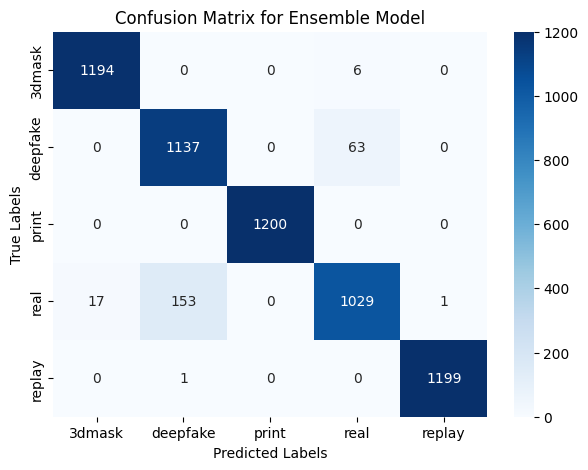

In [140]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [141]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3703       2700.4808    ± 0.0020
EfficientNetV2       1.7106       584.5852    ± 0.0044
Ensemble             2.0728       482.4347    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.4347 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9952     0.9995       0.9999
Deepfake     0.9844     0.9836       0.9932
Print        0.9983     1.0000       1.0000
Real         0.9745     0.9788       0.9913
Replay       0.9985     1.0000       1.0000


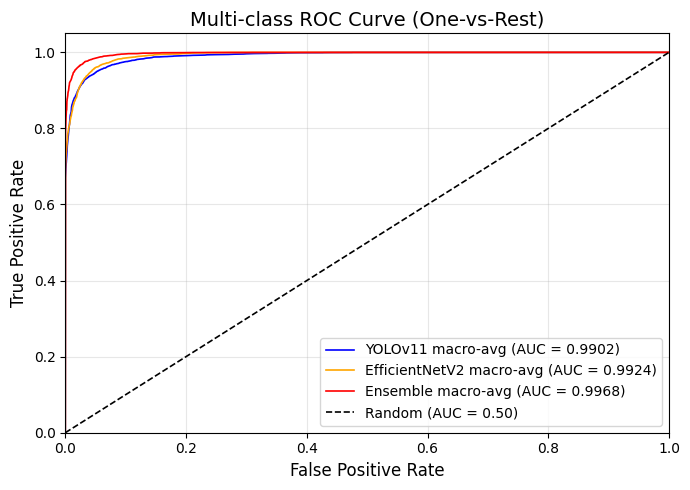


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9902
EfficientNetV2 : 0.9924
Ensemble       : 0.9968


In [142]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Color Jitter

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [143]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_coljit)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [157]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [158]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [159]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [160]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [161]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [162]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5516 Acc: 0.8389 | Val Loss: 1.1290 Acc: 0.8683 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2209 Acc: 0.9357 | Val Loss: 1.0709 Acc: 0.9013 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1653 Acc: 0.9491 | Val Loss: 1.0454 Acc: 0.9142 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1406 Acc: 0.9543 | Val Loss: 1.0328 Acc: 0.9192 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1235 Acc: 0.9604 | Val Loss: 1.0265 Acc: 0.9183 | 
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1135 Acc: 0.9624 | Val Loss: 1.0211 Acc: 0.9145 | 
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1041 Acc: 0.9657 | Val Loss: 1.0145 Acc: 0.9193 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0961 Acc: 0.9681 | Val Loss: 1.0009 Acc: 0.9383 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0908 Acc: 0.9697 | Val Loss: 0.9998 Acc: 0.930

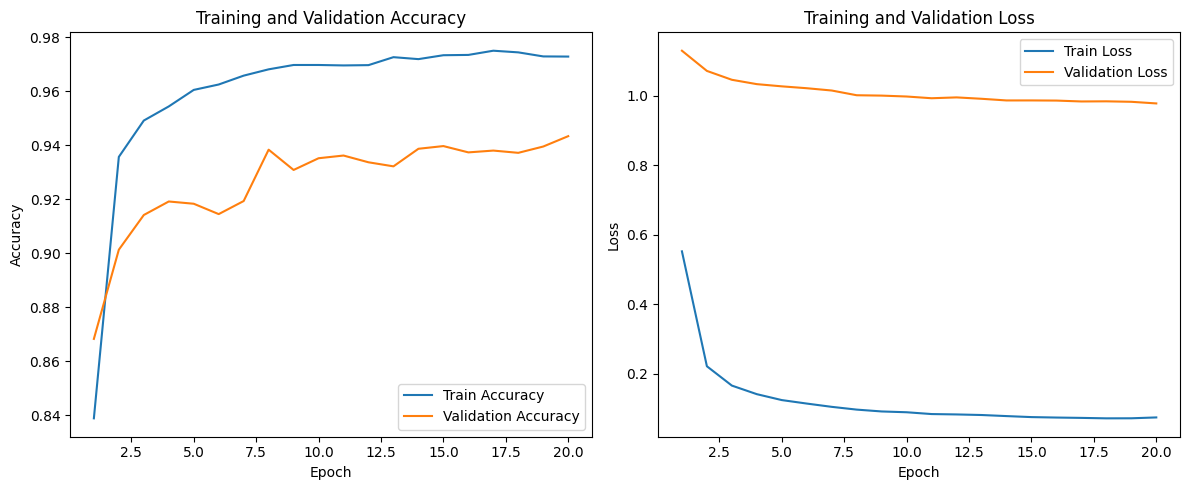

In [163]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [164]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      0.95      0.97      1200
    deepfake       0.83      0.95      0.89      1200
       print       1.00      0.98      0.99      1200
        real       0.91      0.84      0.87      1200
      replay       1.00      0.99      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000



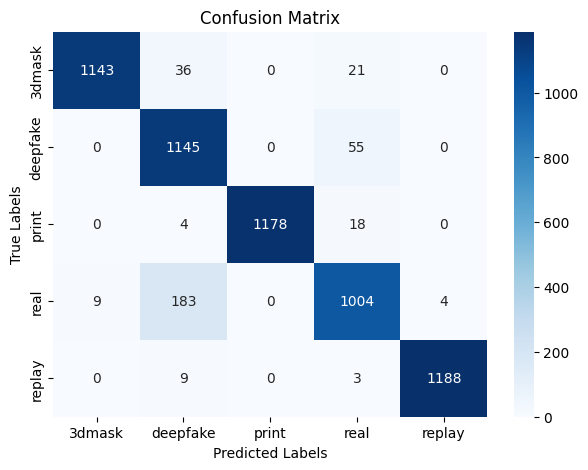

In [165]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [166]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_coljit_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-14_coljit_0.9433/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-14_coljit_0.9433/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-14_coljit_0.9433


## EfficientNetV2

In [168]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [170]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [171]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [173]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [174]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.8915 Acc: 0.8095 | Val Loss: 0.5347 Acc: 0.8957 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4572 Acc: 0.8948 | Val Loss: 0.3715 Acc: 0.9050 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3547 Acc: 0.9024 | Val Loss: 0.3087 Acc: 0.9132 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3045 Acc: 0.9083 | Val Loss: 0.2672 Acc: 0.9172 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2693 Acc: 0.9128 | Val Loss: 0.2397 Acc: 0.9217 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2476 Acc: 0.9182 | Val Loss: 0.2250 Acc: 0.9272 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2296 Acc: 0.9238 | Val Loss: 0.2144 Acc: 0.9283 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2200 Acc: 0.9247 | Val Loss: 0.2006 Acc: 0.9303 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000

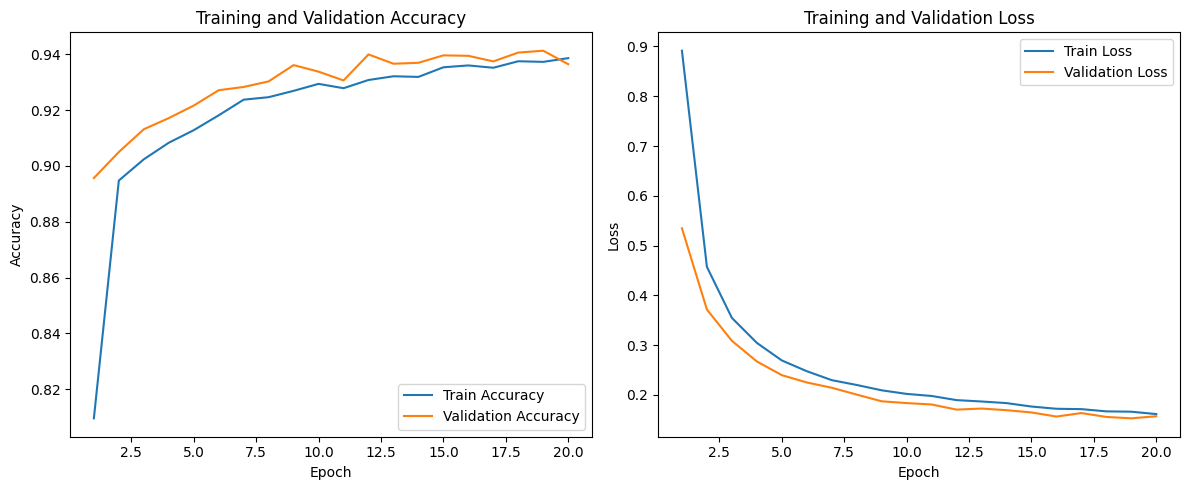

In [175]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.84      0.92      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.90      0.78      0.84      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



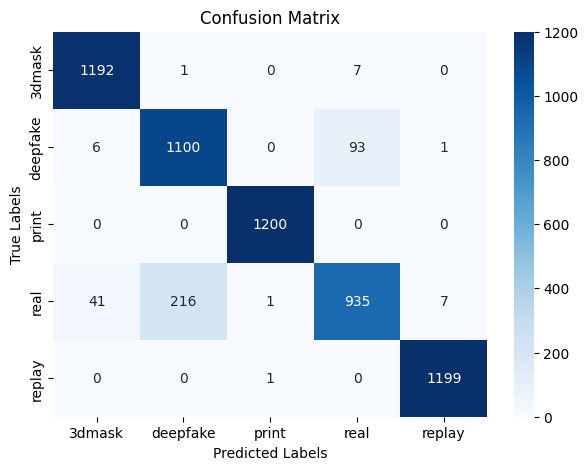

In [177]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [178]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_coljit_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-15_coljit_0.9413/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-15_coljit_0.9413/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-15_coljit_0.9413/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-15_coljit_0.9413


## Ensemble Weighted Average

In [179]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-14_coljit_0.9433/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-15_coljit_0.9413/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [180]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-15_coljit_0.9413/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9392, ACER: 0.1161, Combined Score: 0.4115
Weights [

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      0.95      0.97      1200
    deepfake       0.84      0.96      0.90      1200
       print       1.00      0.98      0.99      1200
        real       0.92      0.84      0.88      1200
      replay       0.99      0.99      0.99      1200

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Accuracy: 0.9457, BPCER: 0.1617, APCER Overall: 0.0183, ACER: 0.0900
APCER per attack class:
* 3dmask: 0.0258
* deepfake: 0.0358
* print: 0.0108
* replay: 0.0008


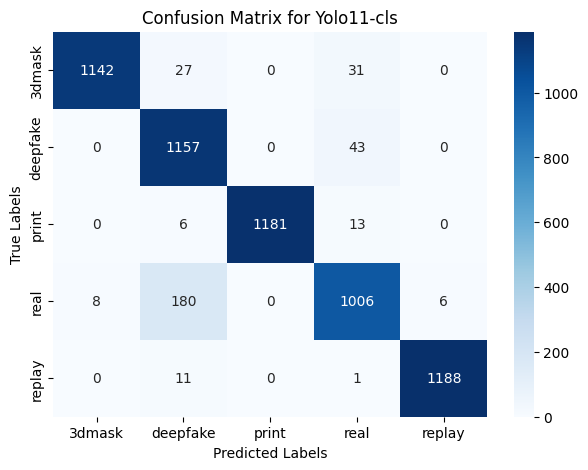


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.83      0.90      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.89      0.78      0.83      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.93      6000
weighted avg       0.94      0.94      0.93      6000

Accuracy: 0.9352, BPCER: 0.2158, APCER Overall: 0.0248, ACER: 0.1203
APCER per attack class:
* 3dmask: 0.0058
* deepfake: 0.0933
* print: 0.0000
* replay: 0.0000


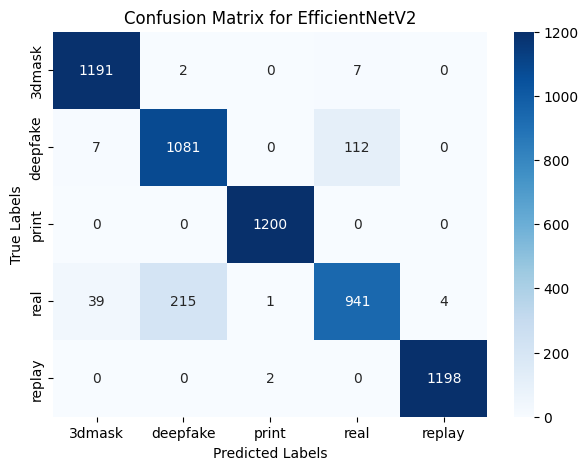


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       1.00      0.99      1.00      1200
    deepfake       0.86      0.98      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.98      0.84      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000

Accuracy: 0.9628, BPCER: 0.1642, APCER Overall: 0.0050, ACER: 0.0846
APCER per attack class:
* 3dmask: 0.0033
* deepfake: 0.0167
* print: 0.0000
* replay: 0.0000


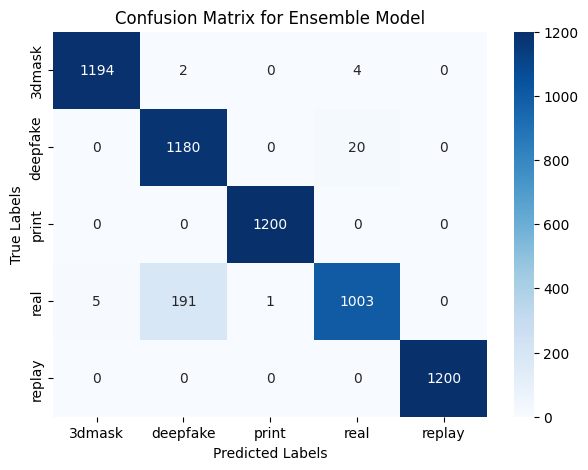

In [181]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [182]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3709       2696.4825    ± 0.0018
EfficientNetV2       1.7098       584.8505    ± 0.0044
Ensemble             2.0737       482.2252    ± 0.0053
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.2252 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9981     0.9996       0.9999
Deepfake     0.9868     0.9851       0.9946
Print        1.0000     1.0000       1.0000
Real         0.9790     0.9818       0.9939
Replay       0.9999     1.0000       1.0000


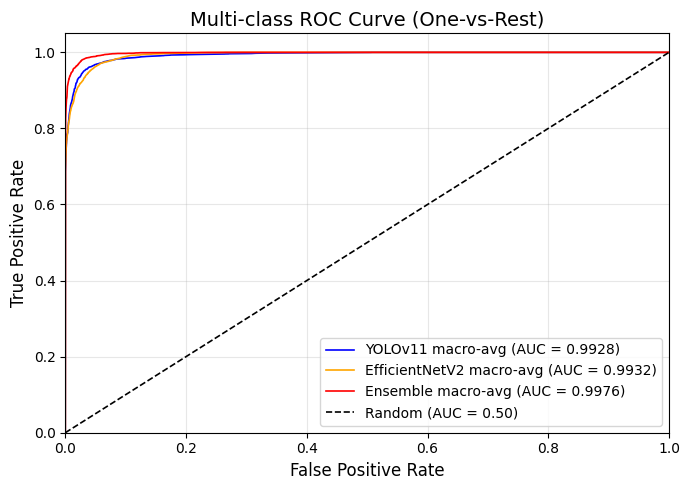


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9928
EfficientNetV2 : 0.9932
Ensemble       : 0.9976


In [183]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Affine

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [184]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_affine)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [186]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [188]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [189]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [190]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [192]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [193]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5618 Acc: 0.8375 | Val Loss: 1.1316 Acc: 0.8692 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2298 Acc: 0.9337 | Val Loss: 1.0676 Acc: 0.9108 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1753 Acc: 0.9449 | Val Loss: 1.0571 Acc: 0.9057 | 
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1506 Acc: 0.9500 | Val Loss: 1.0356 Acc: 0.9212 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1313 Acc: 0.9565 | Val Loss: 1.0327 Acc: 0.9145 | 
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1195 Acc: 0.9598 | Val Loss: 1.0218 Acc: 0.9178 | 
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1145 Acc: 0.9607 | Val Loss: 1.0119 Acc: 0.9293 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.1049 Acc: 0.9634 | Val Loss: 1.0116 Acc: 0.9225 | 
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.1034 Acc: 0.9639 | Val Loss: 1.0015 Acc: 0.9343 | >>> New best model saved!
Epoch 10/20 =>  LR: 

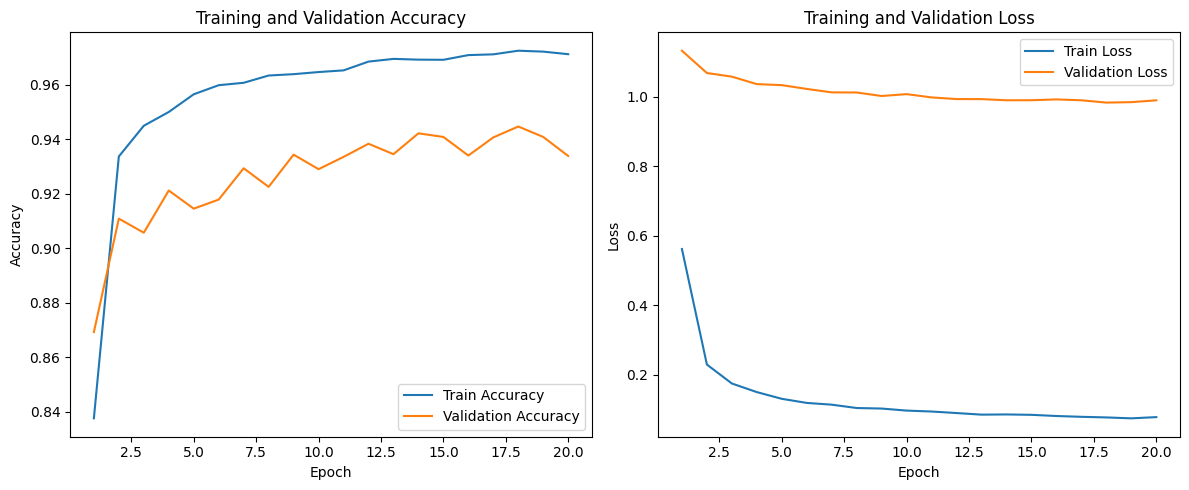

In [194]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [195]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      0.96      0.97      1200
    deepfake       0.84      0.96      0.90      1200
       print       1.00      0.97      0.98      1200
        real       0.90      0.86      0.88      1200
      replay       1.00      0.97      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000



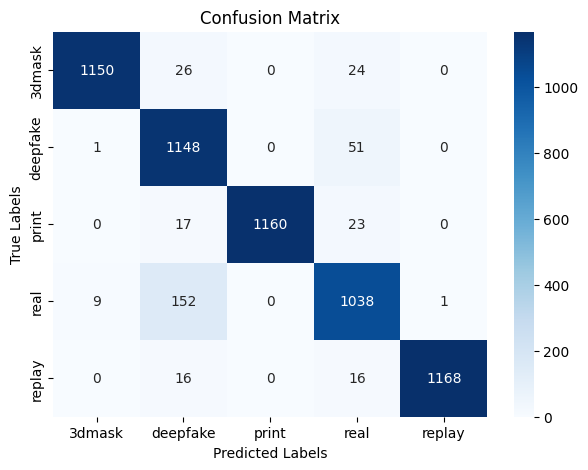

In [196]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [197]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_affine_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-16_affine_0.9447/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-16_affine_0.9447/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-16_affine_0.9447


## EfficientNetV2

In [199]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [201]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [202]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [203]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [204]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9117 Acc: 0.7884 | Val Loss: 0.5561 Acc: 0.8927 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4676 Acc: 0.8873 | Val Loss: 0.3625 Acc: 0.9078 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3611 Acc: 0.8986 | Val Loss: 0.3043 Acc: 0.9202 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3077 Acc: 0.9072 | Val Loss: 0.2690 Acc: 0.9248 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2737 Acc: 0.9134 | Val Loss: 0.2417 Acc: 0.9288 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2515 Acc: 0.9164 | Val Loss: 0.2225 Acc: 0.9310 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2347 Acc: 0.9228 | Val Loss: 0.2014 Acc: 0.9337 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2231 Acc: 0.9216 | Val Loss: 0.1989 Acc: 0.9347 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000

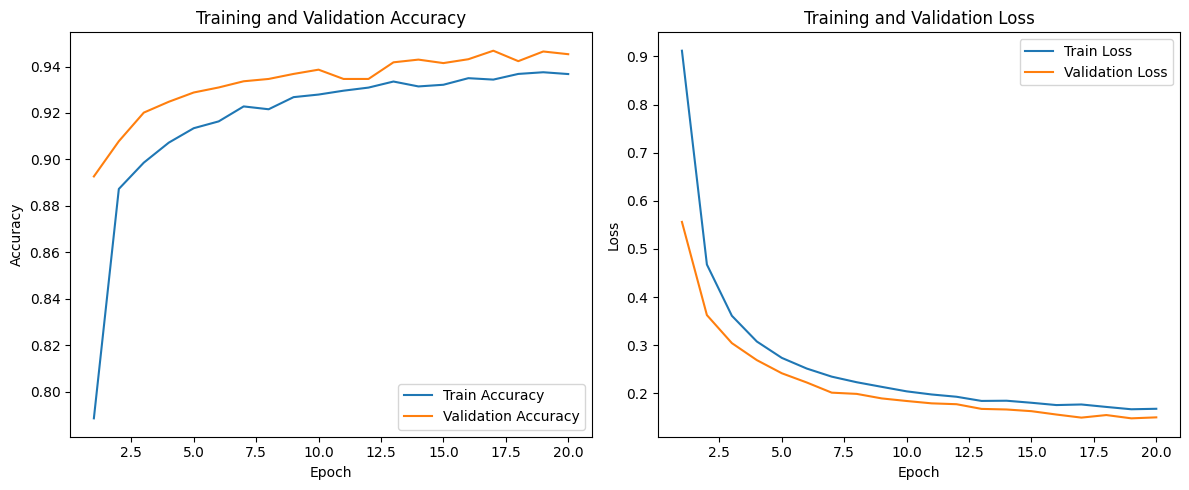

In [205]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [206]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.83      0.93      0.88      1200
       print       1.00      1.00      1.00      1200
        real       0.91      0.78      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



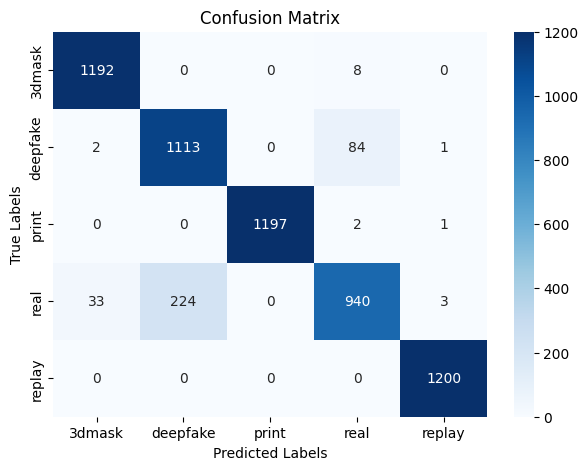

In [207]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [208]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_affine_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-16_affine_0.9468/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-16_affine_0.9468/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-16_affine_0.9468/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-16_affine_0.9468


## Ensemble Weighted Average

In [210]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-16_affine_0.9447/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-16_affine_0.9468/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [211]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-16_affine_0.9468/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9495, ACER: 0.0989, Combined Score: 0.4253
Weights [

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      0.96      0.97      1200
    deepfake       0.84      0.96      0.90      1200
       print       1.00      0.96      0.98      1200
        real       0.90      0.85      0.88      1200
      replay       1.00      0.98      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000

Accuracy: 0.9432, BPCER: 0.1483, APCER Overall: 0.0227, ACER: 0.0855
APCER per attack class:
* 3dmask: 0.0225
* deepfake: 0.0392
* print: 0.0208
* replay: 0.0083


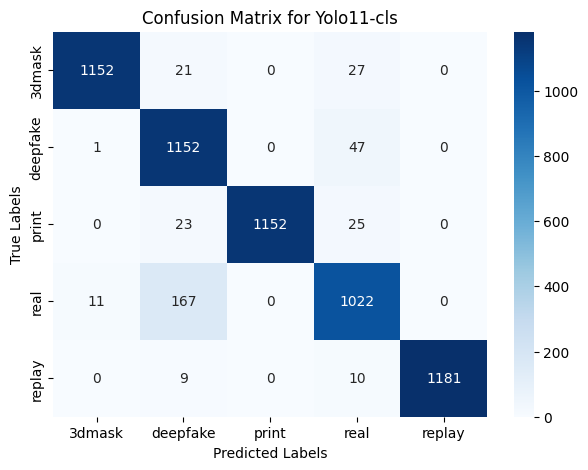


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.83      0.93      0.88      1200
       print       1.00      1.00      1.00      1200
        real       0.91      0.77      0.84      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9385, BPCER: 0.2283, APCER Overall: 0.0190, ACER: 0.1236
APCER per attack class:
* 3dmask: 0.0075
* deepfake: 0.0667
* print: 0.0008
* replay: 0.0008


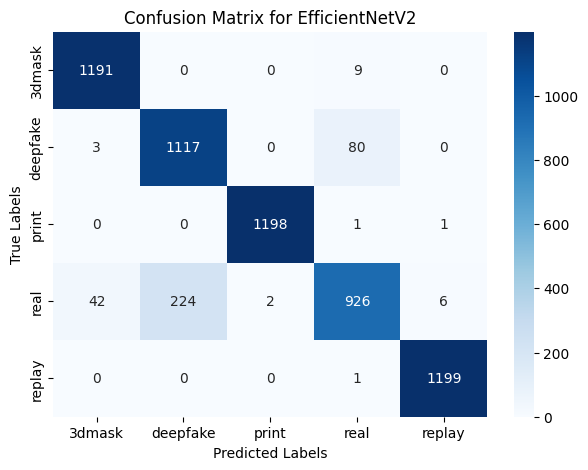


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      0.99      0.99      1200
    deepfake       0.87      0.97      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.97      0.85      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000

Accuracy: 0.9637, BPCER: 0.1492, APCER Overall: 0.0073, ACER: 0.0782
APCER per attack class:
* 3dmask: 0.0025
* deepfake: 0.0258
* print: 0.0008
* replay: 0.0000


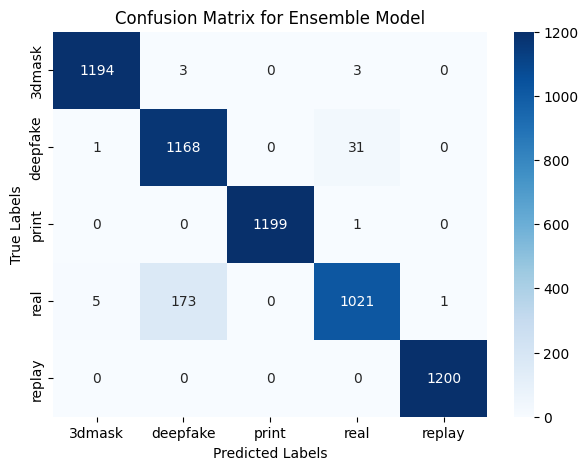

In [212]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [213]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3685       2713.5778    ± 0.0016
EfficientNetV2       1.7100       584.7824    ± 0.0044
Ensemble             2.0714       482.7716    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.7716 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9980     0.9997       1.0000
Deepfake     0.9894     0.9836       0.9953
Print        0.9999     1.0000       1.0000
Real         0.9853     0.9784       0.9943
Replay       0.9999     1.0000       1.0000


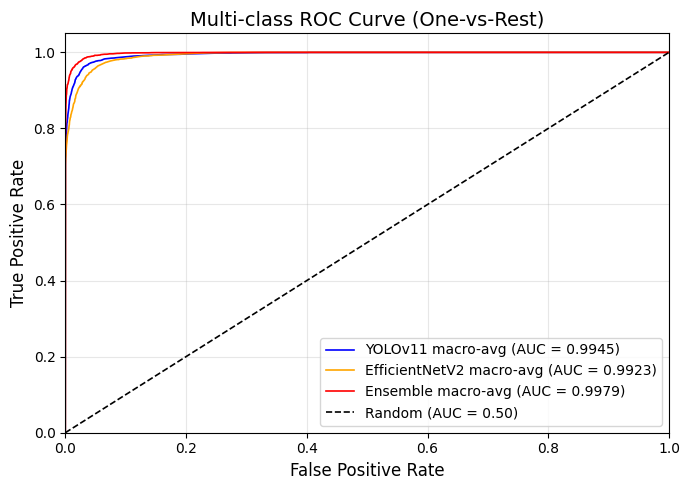


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9945
EfficientNetV2 : 0.9923
Ensemble       : 0.9979


In [214]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Perspective

## Dataset Concat

In [4]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [216]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_perspective)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [217]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [219]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [221]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [222]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [224]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [225]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5320 Acc: 0.8473 | Val Loss: 1.1248 Acc: 0.8850 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2136 Acc: 0.9359 | Val Loss: 1.0646 Acc: 0.9168 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1588 Acc: 0.9515 | Val Loss: 1.0462 Acc: 0.9173 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1339 Acc: 0.9575 | Val Loss: 1.0384 Acc: 0.9065 | 
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1190 Acc: 0.9608 | Val Loss: 1.0259 Acc: 0.9182 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1075 Acc: 0.9644 | Val Loss: 1.0158 Acc: 0.9227 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.0959 Acc: 0.9686 | Val Loss: 1.0107 Acc: 0.9255 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0914 Acc: 0.9706 | Val Loss: 1.0067 Acc: 0.9272 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0858 Acc: 0.9699 | Va

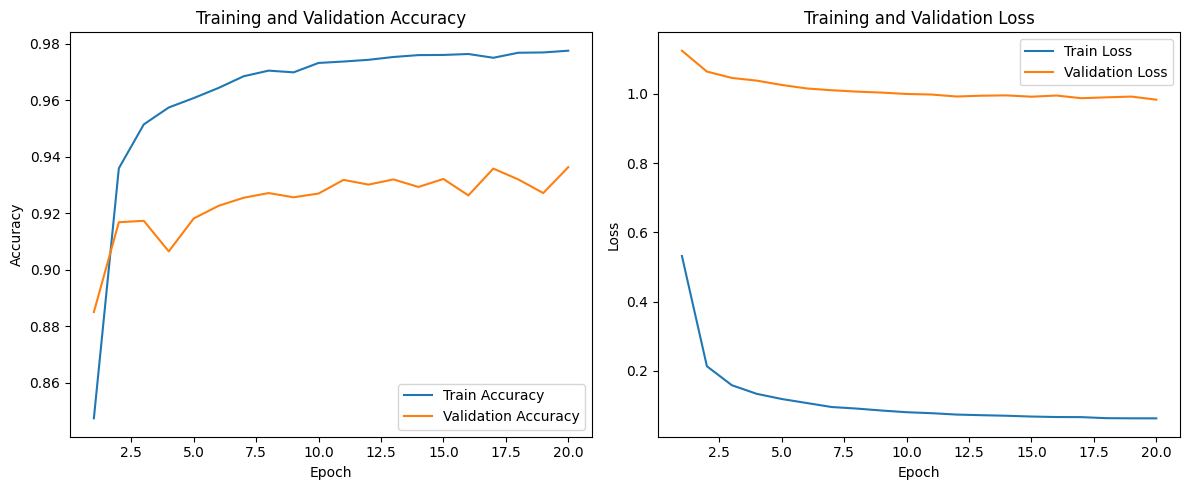

In [226]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [227]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.98      0.97      0.97      1200
    deepfake       0.80      0.96      0.87      1200
       print       1.00      0.96      0.98      1200
        real       0.91      0.80      0.85      1200
      replay       1.00      0.98      0.99      1200

    accuracy                           0.93      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.93      0.93      6000



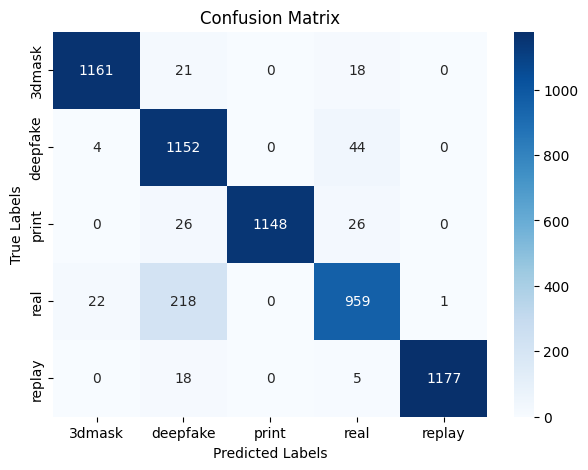

In [228]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [229]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_perspective_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-16_perspective_0.9363/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-16_perspective_0.9363/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-16_perspective_0.9363


## EfficientNetV2

In [234]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [235]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [236]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [237]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [238]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9143 Acc: 0.7841 | Val Loss: 0.5434 Acc: 0.8948 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4547 Acc: 0.8918 | Val Loss: 0.3756 Acc: 0.9035 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3488 Acc: 0.9033 | Val Loss: 0.3014 Acc: 0.9182 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.2941 Acc: 0.9123 | Val Loss: 0.2645 Acc: 0.9237 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2644 Acc: 0.9150 | Val Loss: 0.2456 Acc: 0.9213 | 
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2428 Acc: 0.9195 | Val Loss: 0.2277 Acc: 0.9255 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2252 Acc: 0.9221 | Val Loss: 0.2117 Acc: 0.9290 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2092 Acc: 0.9289 | Val Loss: 0.1986 Acc: 0.9310 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.203

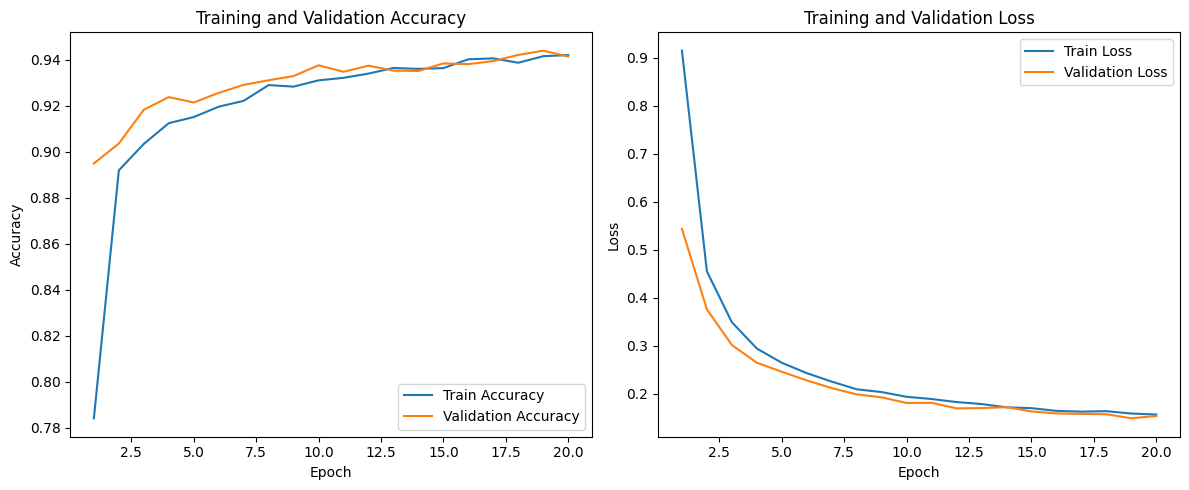

In [240]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [241]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.84      0.91      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.89      0.80      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



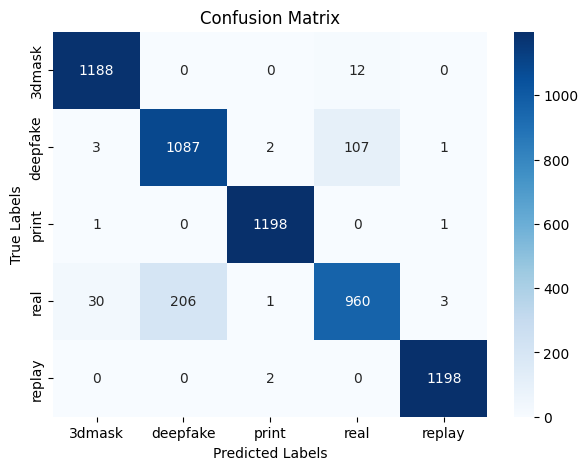

In [242]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [243]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_perspective_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-17_perspective_0.9438/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-17_perspective_0.9438/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-17_perspective_0.9438/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-17_perspective_0.9438


## Ensemble Weighted Average

In [245]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-16_perspective_0.9363/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-17_perspective_0.9438/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [247]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-17_perspective_0.9438/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9435, ACER: 0.1043, Combined Score: 0.4196
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9435, ACER: 0.1043, Combined Score: 0.4196
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9437, ACER: 0.1042, Combined Score: 0.4198
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9438, ACER: 0.1037, Combined Score: 0.4200
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9438, ACER: 0.1037, Combined Score: 0.4200
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9440, ACER: 0.1033, Combined Score: 0.4203
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9442, ACER: 0.1029, Combined Score: 0.4206
Weig

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.97      0.96      0.97      1200
    deepfake       0.81      0.96      0.88      1200
       print       1.00      0.95      0.97      1200
        real       0.91      0.82      0.86      1200
      replay       1.00      0.97      0.99      1200

    accuracy                           0.93      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.93      0.93      6000

Accuracy: 0.9332, BPCER: 0.1842, APCER Overall: 0.0198, ACER: 0.1020
APCER per attack class:
* 3dmask: 0.0133
* deepfake: 0.0333
* print: 0.0275
* replay: 0.0050


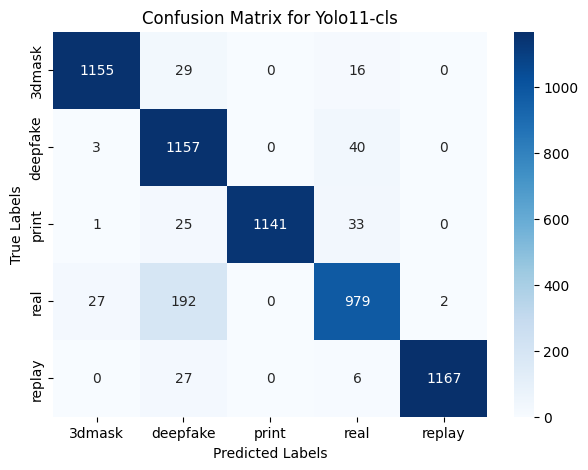


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.84      0.90      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.80      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9367, BPCER: 0.2042, APCER Overall: 0.0260, ACER: 0.1151
APCER per attack class:
* 3dmask: 0.0108
* deepfake: 0.0933
* print: 0.0000
* replay: 0.0000


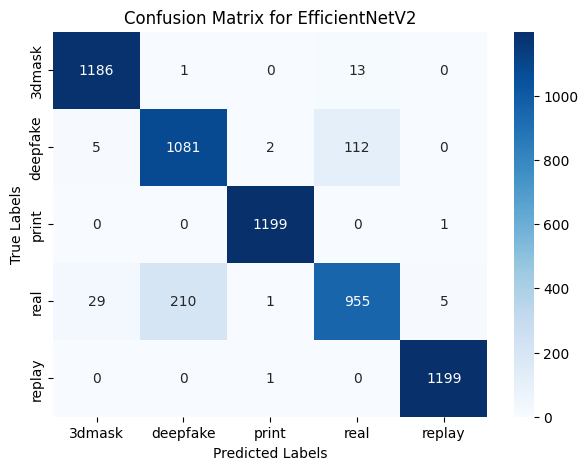


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      0.99      0.99      1200
    deepfake       0.86      0.98      0.91      1200
       print       1.00      1.00      1.00      1200
        real       0.97      0.84      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9615, BPCER: 0.1625, APCER Overall: 0.0065, ACER: 0.0845
APCER per attack class:
* 3dmask: 0.0033
* deepfake: 0.0225
* print: 0.0000
* replay: 0.0000


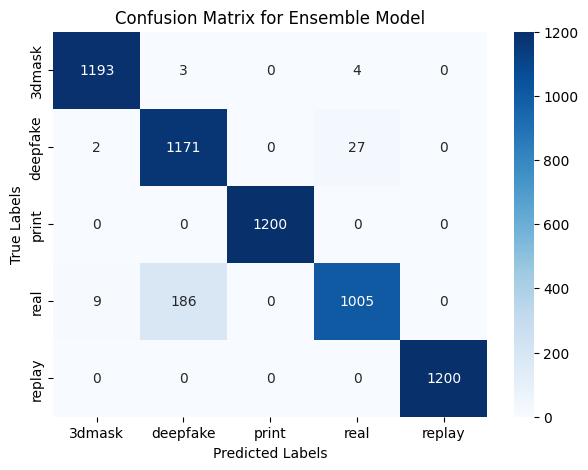

In [248]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [249]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3674       2721.7483    ± 0.0014
EfficientNetV2       1.7096       584.9306    ± 0.0044
Ensemble             2.0731       482.3791    ± 0.0053
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.3791 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9973     0.9997       0.9999
Deepfake     0.9843     0.9847       0.9941
Print        0.9997     1.0000       1.0000
Real         0.9744     0.9815       0.9931
Replay       0.9996     1.0000       1.0000


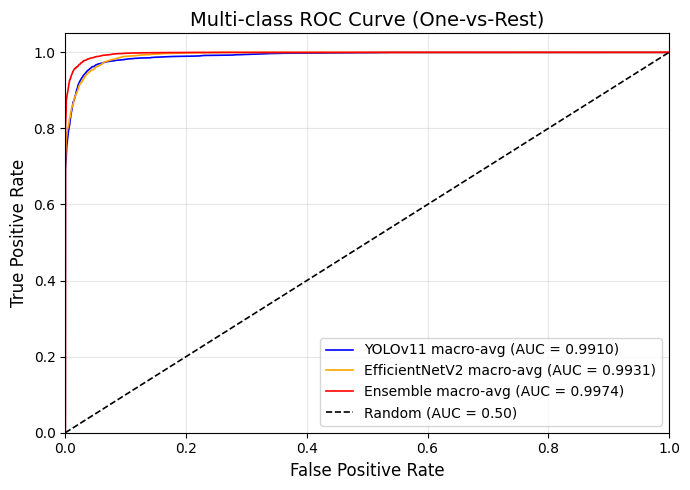


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9910
EfficientNetV2 : 0.9931
Ensemble       : 0.9974


In [250]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Noise

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [251]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_noise)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [253]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [260]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [261]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [262]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [263]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [264]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5675 Acc: 0.8339 | Val Loss: 1.0770 Acc: 0.9202 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2615 Acc: 0.9142 | Val Loss: 1.0268 Acc: 0.9368 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.2065 Acc: 0.9301 | Val Loss: 1.0065 Acc: 0.9452 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1765 Acc: 0.9371 | Val Loss: 0.9992 Acc: 0.9468 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1608 Acc: 0.9411 | Val Loss: 0.9903 Acc: 0.9513 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1457 Acc: 0.9478 | Val Loss: 0.9849 Acc: 0.9517 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1415 Acc: 0.9484 | Val Loss: 0.9816 Acc: 0.9545 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.1321 Acc: 0.9516 | Val Loss: 0.9788 Acc: 0.9545 | 
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.1300 Acc: 0.9515 | Va

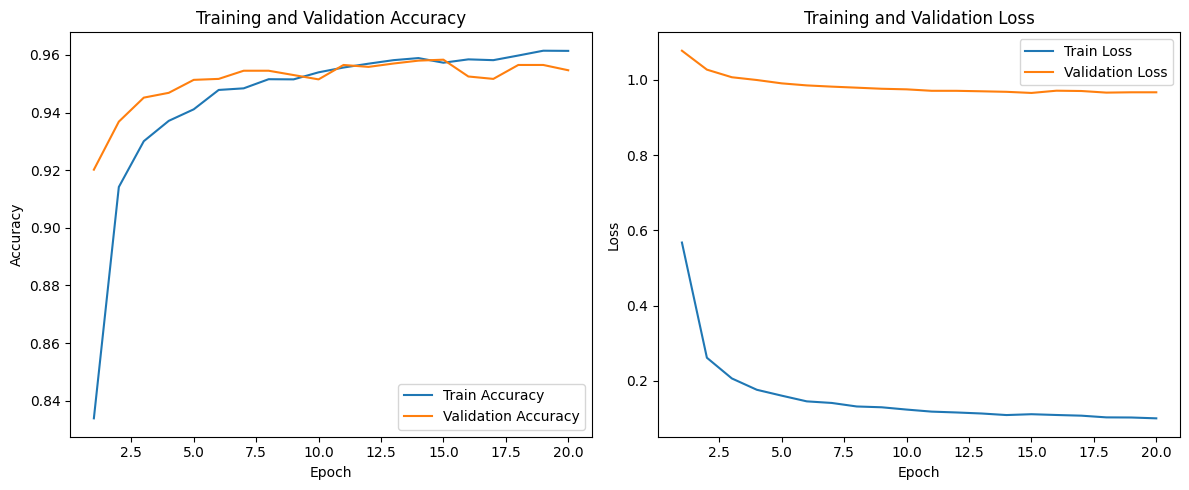

In [265]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [266]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.90      0.89      0.90      1200
       print       1.00      1.00      1.00      1200
        real       0.90      0.89      0.89      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



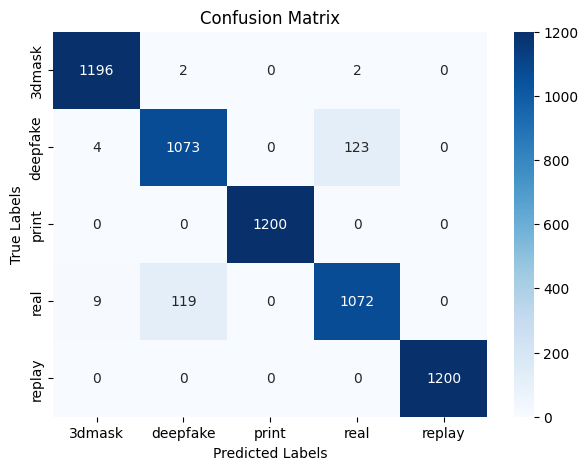

In [267]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [268]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_noise_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-18_noise_0.9583/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-18_noise_0.9583/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-18_noise_0.9583


## EfficientNetV2

In [271]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [273]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [274]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [275]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [276]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9033 Acc: 0.7998 | Val Loss: 0.5439 Acc: 0.8985 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4738 Acc: 0.8889 | Val Loss: 0.3669 Acc: 0.9117 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3690 Acc: 0.8979 | Val Loss: 0.3077 Acc: 0.9167 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3155 Acc: 0.9059 | Val Loss: 0.2628 Acc: 0.9217 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2801 Acc: 0.9124 | Val Loss: 0.2435 Acc: 0.9248 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2647 Acc: 0.9131 | Val Loss: 0.2242 Acc: 0.9278 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2478 Acc: 0.9136 | Val Loss: 0.2134 Acc: 0.9260 | 
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2324 Acc: 0.9196 | Val Loss: 0.1998 Acc: 0.9305 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.221

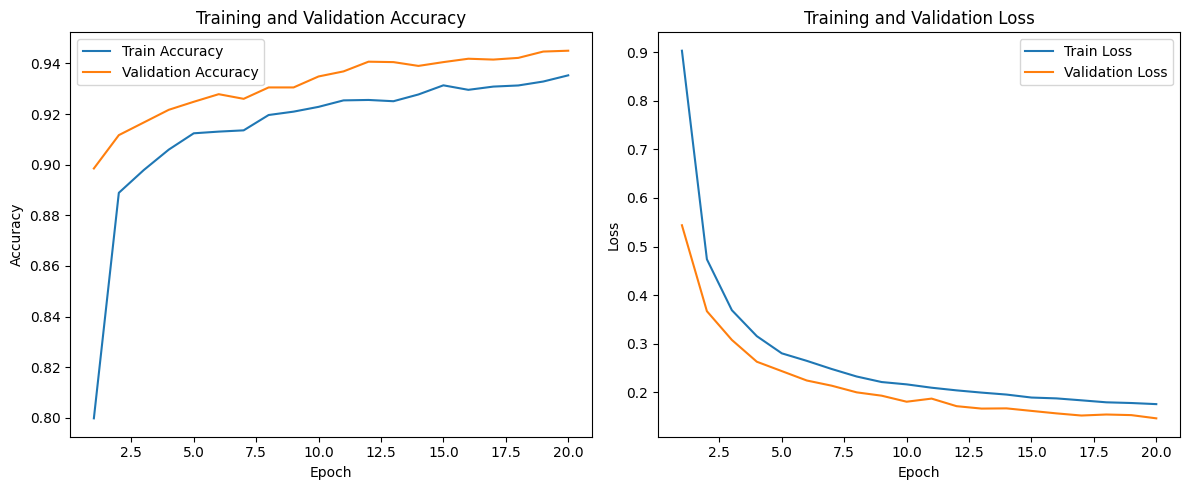

In [277]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [278]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.80      0.97      0.88      1200
       print       1.00      1.00      1.00      1200
        real       0.96      0.74      0.83      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000



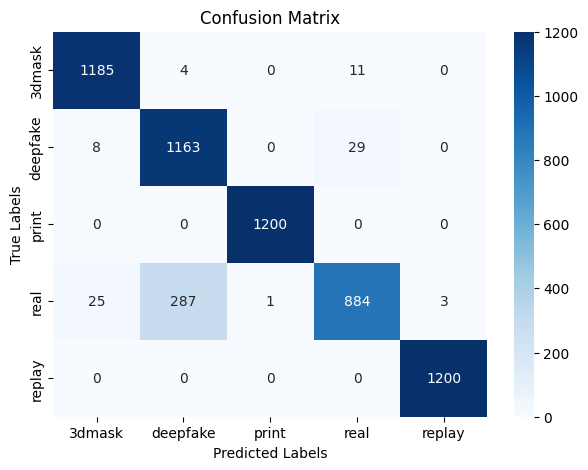

In [279]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [280]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_noise_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-18_noise_0.9450/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-18_noise_0.9450/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-18_noise_0.9450/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-18_noise_0.9450


## Ensemble Weighted Average

In [281]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-18_noise_0.9583/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-18_noise_0.9450/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [284]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-18_noise_0.9450/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9405, ACER: 0.1289, Combined Score: 0.4058
Weights [Y

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.90      0.89      0.90      1200
       print       1.00      1.00      1.00      1200
        real       0.90      0.90      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9583, BPCER: 0.0992, APCER Overall: 0.0260, ACER: 0.0626
APCER per attack class:
* 3dmask: 0.0008
* deepfake: 0.1033
* print: 0.0000
* replay: 0.0000


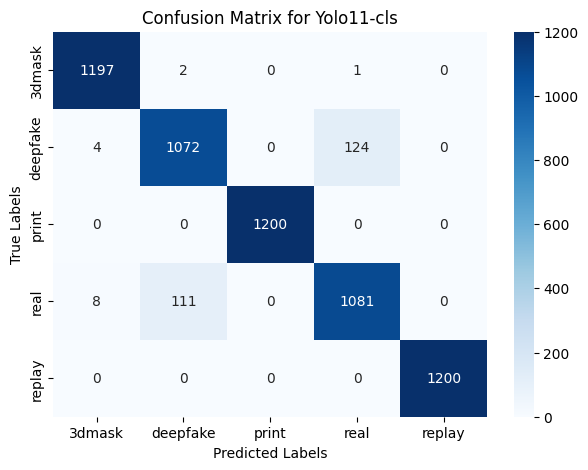


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.80      0.97      0.88      1200
       print       1.00      1.00      1.00      1200
        real       0.96      0.74      0.83      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000

Accuracy: 0.9390, BPCER: 0.2617, APCER Overall: 0.0083, ACER: 0.1350
APCER per attack class:
* 3dmask: 0.0075
* deepfake: 0.0258
* print: 0.0000
* replay: 0.0000


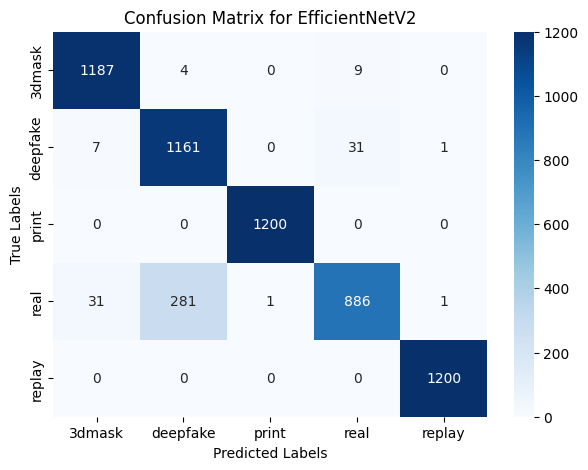


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      1.00      1200
    deepfake       0.88      0.96      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.95      0.86      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000

Accuracy: 0.9643, BPCER: 0.1350, APCER Overall: 0.0106, ACER: 0.0728
APCER per attack class:
* 3dmask: 0.0008
* deepfake: 0.0417
* print: 0.0000
* replay: 0.0000


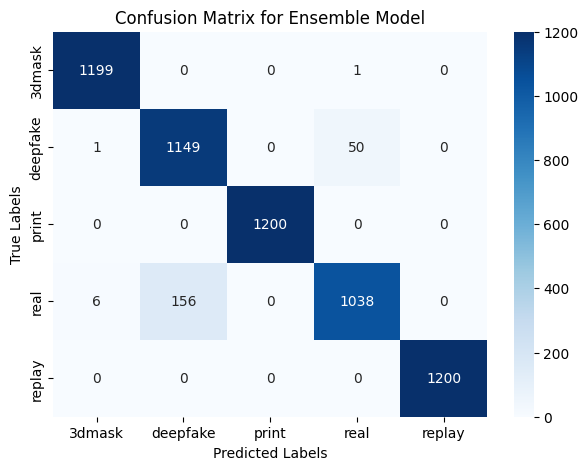

In [285]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [286]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3666       2727.4148    ± 0.0009
EfficientNetV2       1.7088       585.2119    ± 0.0044
Ensemble             2.0700       483.1011    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 483.1011 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       1.0000     0.9996       1.0000
Deepfake     0.9922     0.9861       0.9947
Print        1.0000     1.0000       1.0000
Real         0.9916     0.9828       0.9943
Replay       1.0000     1.0000       1.0000


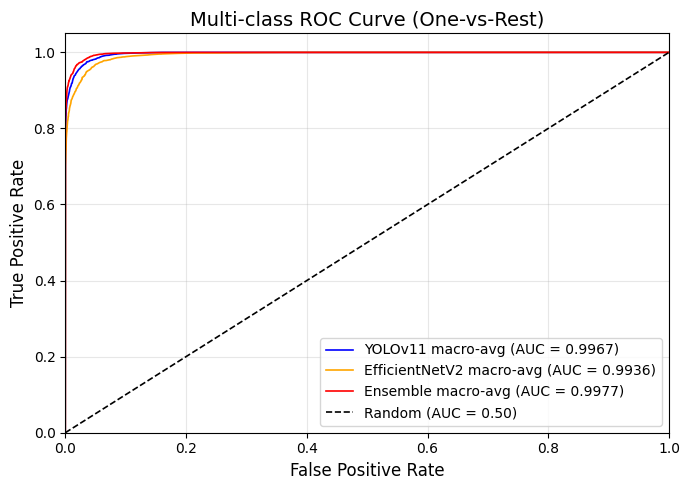


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9967
EfficientNetV2 : 0.9936
Ensemble       : 0.9977


In [287]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Blur

## Dataset Concat

In [5]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [288]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_blur)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [290]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [292]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [294]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [295]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [296]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [297]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5519 Acc: 0.8417 | Val Loss: 1.1218 Acc: 0.8840 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2199 Acc: 0.9355 | Val Loss: 1.0745 Acc: 0.8965 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1662 Acc: 0.9462 | Val Loss: 1.0572 Acc: 0.8985 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1397 Acc: 0.9548 | Val Loss: 1.0400 Acc: 0.9075 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1229 Acc: 0.9610 | Val Loss: 1.0348 Acc: 0.9082 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1124 Acc: 0.9626 | Val Loss: 1.0251 Acc: 0.9125 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1010 Acc: 0.9681 | Val Loss: 1.0158 Acc: 0.9227 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0934 Acc: 0.9696 | Val Loss: 1.0151 Acc: 0.9215 | 
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0917 Acc: 0.9675 | Va

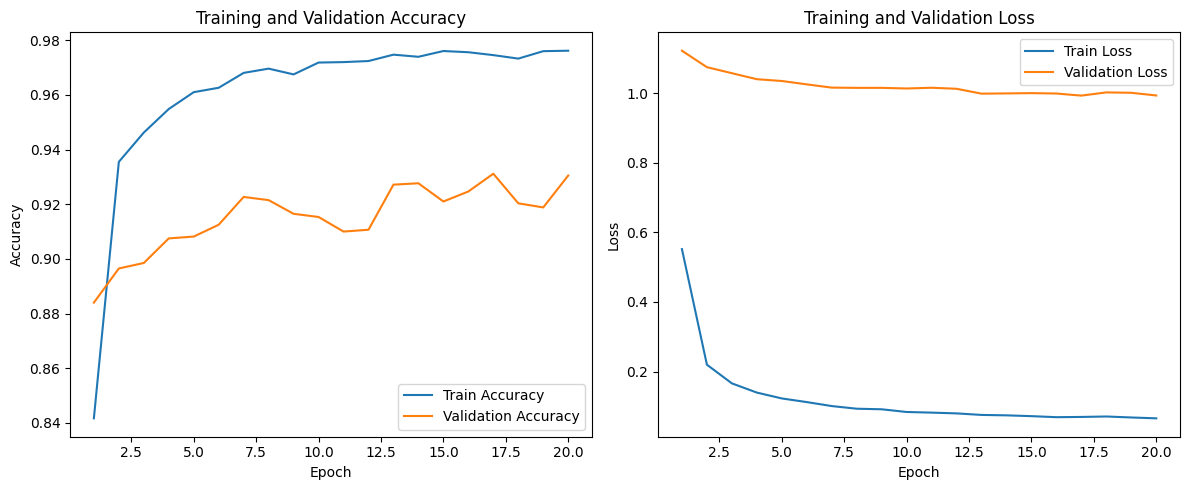

In [298]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [299]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.98      0.95      0.96      1200
    deepfake       0.85      0.92      0.88      1200
       print       1.00      0.94      0.97      1200
        real       0.82      0.84      0.83      1200
      replay       0.99      0.97      0.98      1200

    accuracy                           0.92      6000
   macro avg       0.93      0.92      0.93      6000
weighted avg       0.93      0.92      0.93      6000



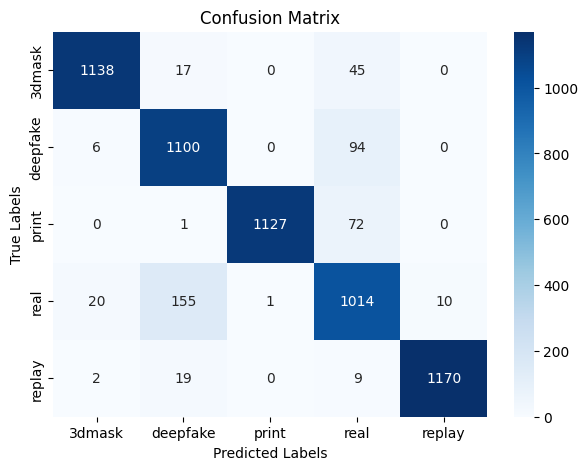

In [300]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [301]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_blur_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-19_blur_0.9312/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-19_blur_0.9312/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-19_blur_0.9312


## EfficientNetV2

In [302]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [303]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [304]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [305]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [306]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9118 Acc: 0.7873 | Val Loss: 0.5640 Acc: 0.8822 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4688 Acc: 0.8900 | Val Loss: 0.3745 Acc: 0.9025 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3586 Acc: 0.9002 | Val Loss: 0.3240 Acc: 0.9097 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.3050 Acc: 0.9092 | Val Loss: 0.2720 Acc: 0.9205 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2714 Acc: 0.9129 | Val Loss: 0.2439 Acc: 0.9232 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2499 Acc: 0.9178 | Val Loss: 0.2314 Acc: 0.9220 | 
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2320 Acc: 0.9223 | Val Loss: 0.2149 Acc: 0.9302 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2184 Acc: 0.9260 | Val Loss: 0.2086 Acc: 0.9305 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.211

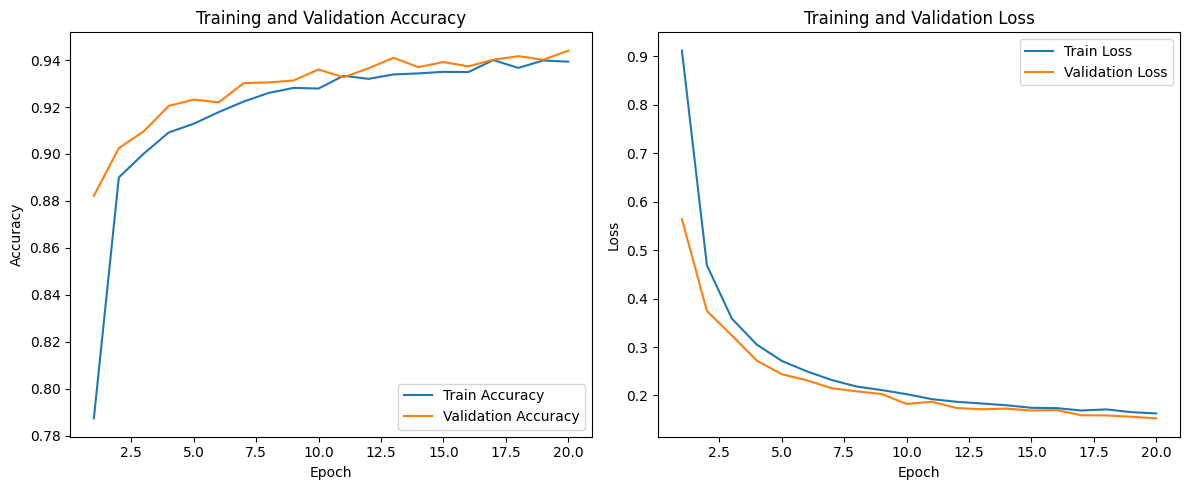

In [307]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [308]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.84      0.90      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.80      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



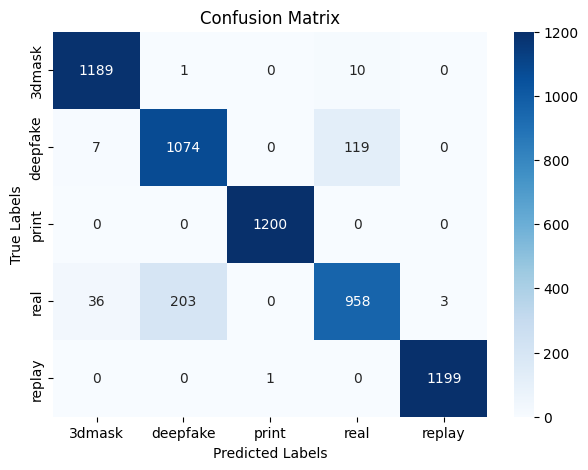

In [309]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [310]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_blur_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-19_blur_0.9440/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-19_blur_0.9440/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-19_blur_0.9440/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-19_blur_0.9440


## Ensemble Weighted Average

In [312]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-19_blur_0.9312/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-19_blur_0.9440/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [314]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-19_blur_0.9440/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9427, ACER: 0.1064, Combined Score: 0.4182
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9427, ACER: 0.1064, Combined Score: 0.4182
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9427, ACER: 0.1064, Combined Score: 0.4182
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9428, ACER: 0.1064, Combined Score: 0.4182
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9430, ACER: 0.1059, Combined Score: 0.4185
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9430, ACER: 0.1059, Combined Score: 0.4185
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9430, ACER: 0.1059, Combined Score: 0.4185
Weights [Yo

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      0.95      0.97      1200
    deepfake       0.85      0.92      0.89      1200
       print       1.00      0.94      0.97      1200
        real       0.84      0.86      0.85      1200
      replay       0.99      0.98      0.99      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9317, BPCER: 0.1408, APCER Overall: 0.0410, ACER: 0.0909
APCER per attack class:
* 3dmask: 0.0325
* deepfake: 0.0750
* print: 0.0517
* replay: 0.0050


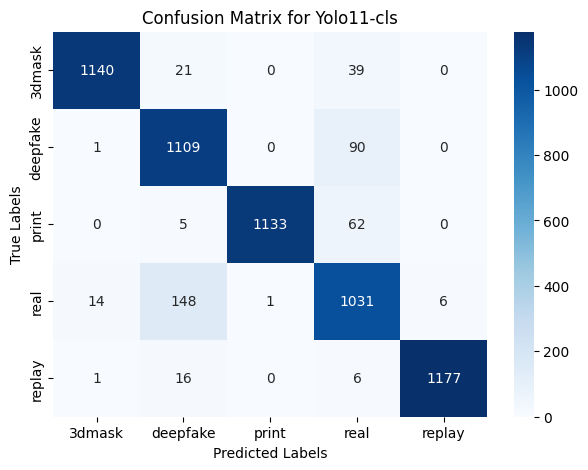


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.97      0.99      0.98      1200
    deepfake       0.84      0.91      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.89      0.81      0.84      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9398, BPCER: 0.1950, APCER Overall: 0.0252, ACER: 0.1101
APCER per attack class:
* 3dmask: 0.0100
* deepfake: 0.0908
* print: 0.0000
* replay: 0.0000


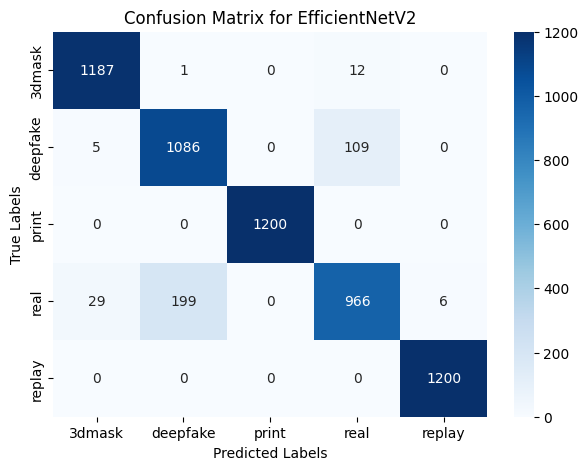


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.88      0.96      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.95      0.86      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9627, BPCER: 0.1400, APCER Overall: 0.0115, ACER: 0.0757
APCER per attack class:
* 3dmask: 0.0033
* deepfake: 0.0408
* print: 0.0017
* replay: 0.0000


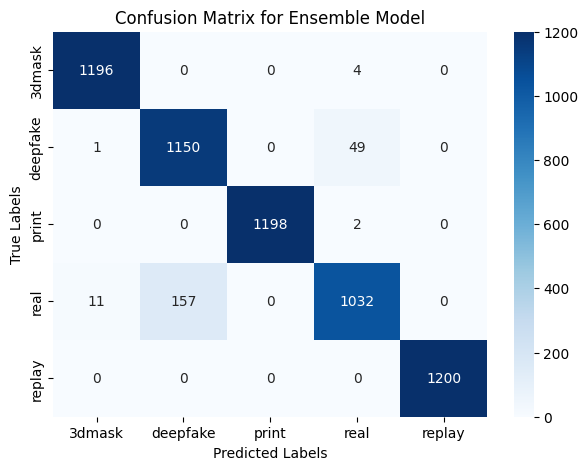

In [315]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [316]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3681       2716.5604    ± 0.0010
EfficientNetV2       1.7103       584.6856    ± 0.0044
Ensemble             2.0735       482.2772    ± 0.0052
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.2772 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9971     0.9997       1.0000
Deepfake     0.9884     0.9849       0.9939
Print        0.9982     1.0000       1.0000
Real         0.9787     0.9816       0.9923
Replay       0.9994     1.0000       1.0000


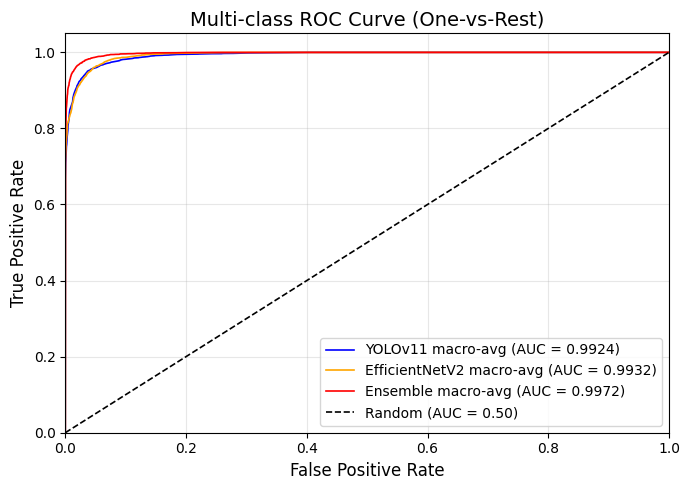


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9924
EfficientNetV2 : 0.9932
Ensemble       : 0.9972


In [317]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)

# Erase

## Dataset Concat

In [ ]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [319]:
# Path splitted dataset
data_dir = "/kaggle/input/dataset-s1-v2-splitted"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_erase)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [321]:
# Create Data Loader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## YOLOv11

In [323]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [325]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [326]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [327]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [328]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.5150 Acc: 0.8570 | Val Loss: 1.1209 Acc: 0.8805 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.2106 Acc: 0.9386 | Val Loss: 1.0747 Acc: 0.8930 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.1603 Acc: 0.9487 | Val Loss: 1.0566 Acc: 0.9013 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.1316 Acc: 0.9576 | Val Loss: 1.0373 Acc: 0.9083 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1176 Acc: 0.9612 | Val Loss: 1.0214 Acc: 0.9235 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1037 Acc: 0.9667 | Val Loss: 1.0176 Acc: 0.9210 | 
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.0980 Acc: 0.9662 | Val Loss: 1.0134 Acc: 0.9213 | 
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.0928 Acc: 0.9684 | Val Loss: 1.0037 Acc: 0.9305 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.0855 Acc: 0.9719 | Val Loss: 1.0123 Acc: 0.917

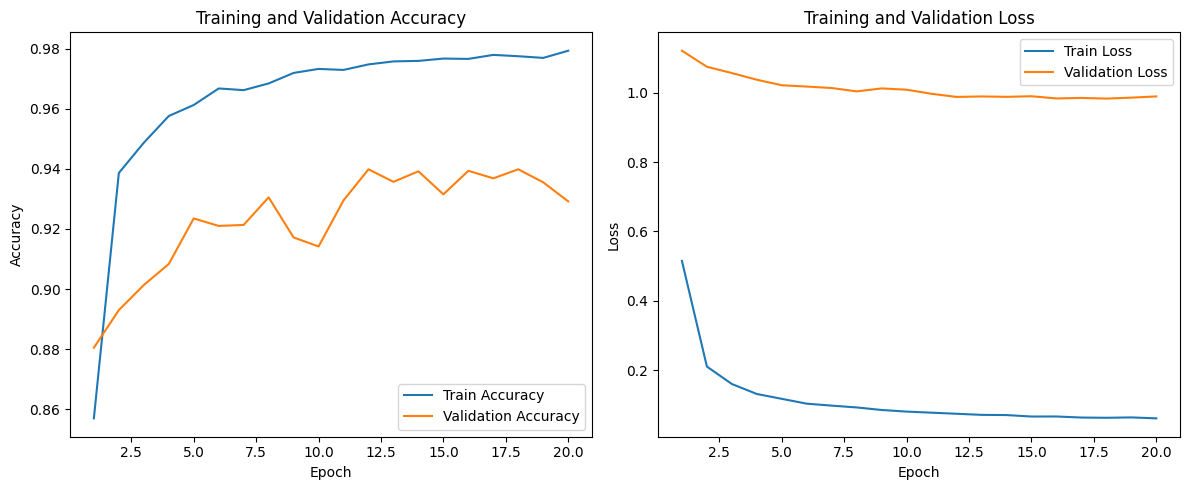

In [329]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [330]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      0.95      0.97      1200
    deepfake       0.84      0.93      0.88      1200
       print       1.00      0.97      0.98      1200
        real       0.87      0.84      0.86      1200
      replay       1.00      0.99      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



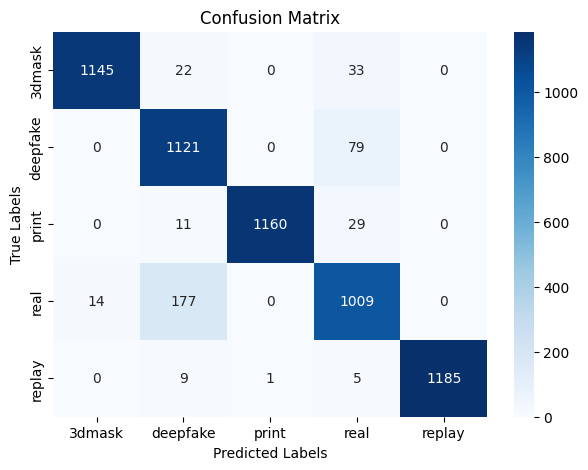

In [331]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [332]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_erase_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_11-08-19_erase_0.9398/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_11-08-19_erase_0.9398/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_11-08-19_erase_0.9398


## EfficientNetV2

In [333]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [335]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [336]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

In [339]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [340]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 0.9056 Acc: 0.7927 | Val Loss: 0.5677 Acc: 0.8803 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.4597 Acc: 0.8934 | Val Loss: 0.3797 Acc: 0.9033 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.3516 Acc: 0.8996 | Val Loss: 0.3049 Acc: 0.9192 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.2994 Acc: 0.9105 | Val Loss: 0.2715 Acc: 0.9165 | 
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.2661 Acc: 0.9162 | Val Loss: 0.2395 Acc: 0.9247 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.2452 Acc: 0.9201 | Val Loss: 0.2268 Acc: 0.9287 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.2287 Acc: 0.9224 | Val Loss: 0.2145 Acc: 0.9278 | 
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.2106 Acc: 0.9274 | Val Loss: 0.2040 Acc: 0.9283 | 
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.2057 Acc: 0.9268 | Val Loss: 0.1989 Acc: 0.9273 | 
Ep

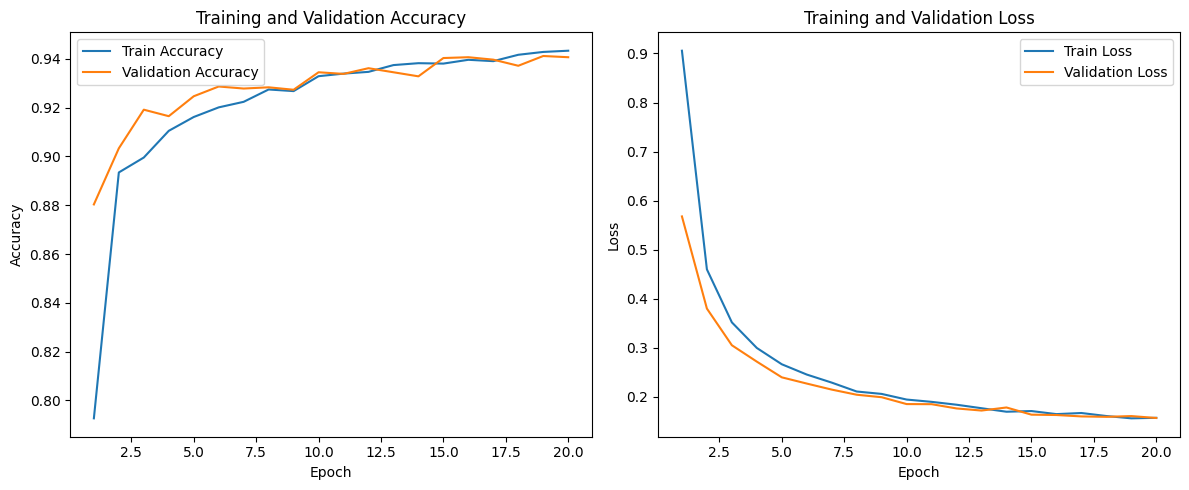

In [341]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [342]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.95      0.99      0.97      1200
    deepfake       0.84      0.89      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.78      0.82      1200
      replay       0.99      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



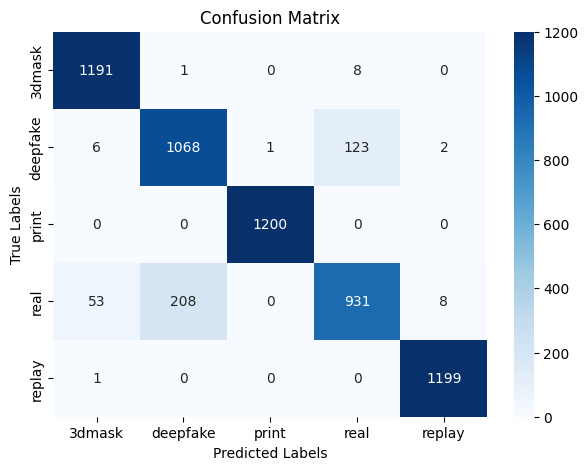

In [343]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [344]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_erase_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_11-08-20_erase_0.9412/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_11-08-20_erase_0.9412/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_11-08-20_erase_0.9412/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_11-08-20_erase_0.9412


## Ensemble Weighted Average

In [346]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5

# Paths
data_dir = "/kaggle/input/dataset-s1-v2-splitted"
folder_save = "/kaggle/working/results"

# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_11-08-19_erase_0.9398/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_11-08-20_erase_0.9412/EfficientNetV2-weights-only-dict.pt')  # Example accuracy

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [348]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader
    )

--- Loading model: Yolo11-cls ---
Model successfully loaded

--- Loading model type: EfficientNetV2 ---
Model successfully loaded from: /kaggle/working/results/effnet_11-08-20_erase_0.9412/EfficientNetV2-weights-only-dict.pt

--- Performing Grid Search for Overall Weights (Accuracy & ACER Combined, α=0.5) ---
Weights [Yolo: 0.0000, EffNet: 1.0000] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0010, EffNet: 0.9990] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0020, EffNet: 0.9980] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0030, EffNet: 0.9970] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0040, EffNet: 0.9960] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0050, EffNet: 0.9950] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Yolo: 0.0060, EffNet: 0.9940] -> Accuracy: 0.9397, ACER: 0.1159, Combined Score: 0.4119
Weights [Y

In [ ]:
# Execution for Grid Search
if __name__ == "__main__":
    print("=== Grid Search for Weights ===")
    # pipeline.grid_search_weights(val_dataloader)

In [ ]:
# Execution for Inference Test
if __name__ == "__main__":
    print("=== Inference Test ===")
    pipeline.predict_single(single_image_path)


=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      0.96      0.97      1200
    deepfake       0.84      0.94      0.89      1200
       print       1.00      0.97      0.98      1200
        real       0.88      0.84      0.86      1200
      replay       1.00      0.99      0.99      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 0.9387, BPCER: 0.1625, APCER Overall: 0.0273, ACER: 0.0949
APCER per attack class:
* 3dmask: 0.0275
* deepfake: 0.0600
* print: 0.0192
* replay: 0.0025


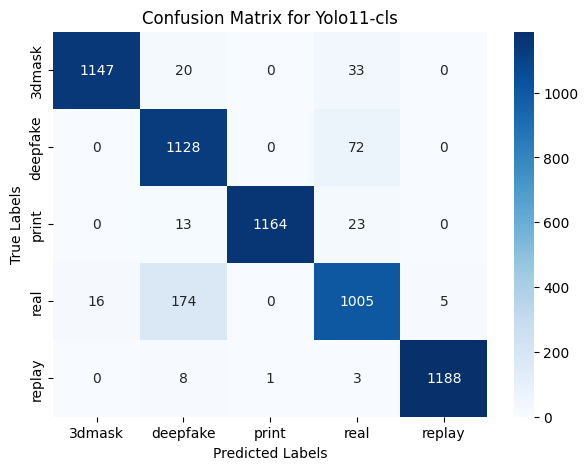


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.95      0.99      0.97      1200
    deepfake       0.82      0.89      0.86      1200
       print       1.00      1.00      1.00      1200
        real       0.88      0.76      0.82      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy: 0.9292, BPCER: 0.2375, APCER Overall: 0.0256, ACER: 0.1316
APCER per attack class:
* 3dmask: 0.0067
* deepfake: 0.0958
* print: 0.0000
* replay: 0.0000


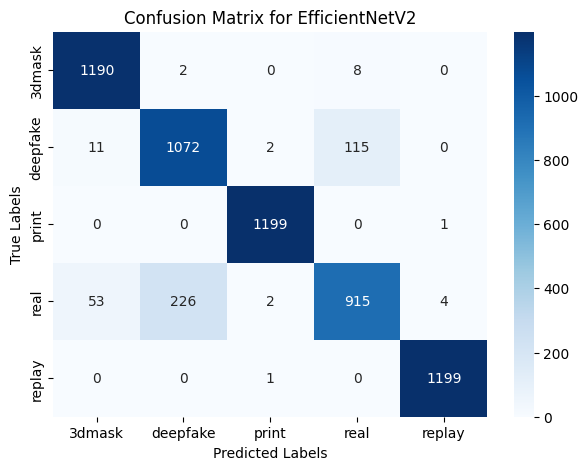


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.87      0.97      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.96      0.84      0.90      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9618, BPCER: 0.1567, APCER Overall: 0.0077, ACER: 0.0822
APCER per attack class:
* 3dmask: 0.0017
* deepfake: 0.0292
* print: 0.0000
* replay: 0.0000


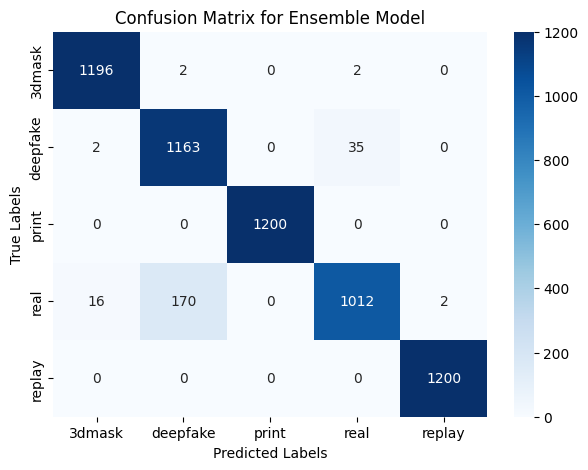

In [349]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [350]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.3672       2723.5339    ± 0.0015
EfficientNetV2       1.7097       584.8985    ± 0.0044
Ensemble             2.0724       482.5302    ± 0.0053
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.5302 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       0.9957     0.9995       0.9999
Deepfake     0.9865     0.9839       0.9937
Print        1.0000     1.0000       1.0000
Real         0.9776     0.9798       0.9919
Replay       1.0000     1.0000       1.0000


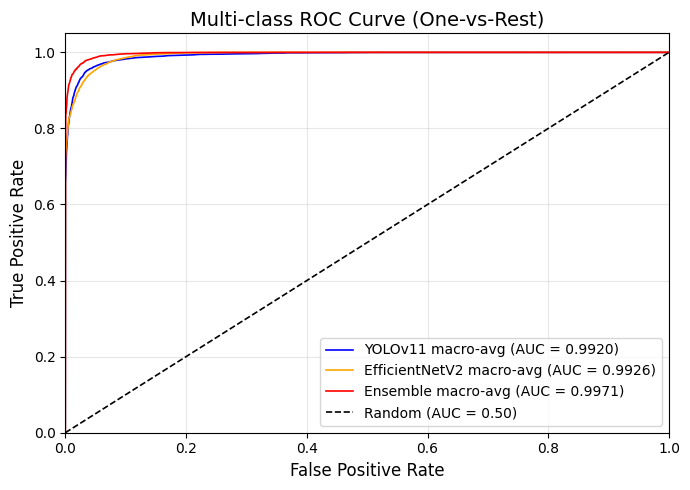


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9920
EfficientNetV2 : 0.9926
Ensemble       : 0.9971


In [351]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)